In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!python -m pip install --upgrade --user jax==0.2.8 jaxlib==0.1.59+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
!git checkout dev;

In [ ]:
cd ..

In [ ]:
!python -m setup.py install

In [2]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)


In [3]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt

import IMNN
print("IMNN version: ", IMNN.__version__)

from IMNN.experimental.jax.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from IMNN.experimental.jax.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from IMNN.experimental.jax.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)


jax version:  0.2.8
IMNN version:  0.2dev


In [4]:
cd examples

[Errno 2] No such file or directory: 'examples'
/mnt/home/tmakinen/repositories/scratch/dev-imnn/imnn/examples


In [5]:
!XLA_FLAGS=--xla_cpu_enable_fast_math=false

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
# bring in 2D simulator
from make_sims import LogNormalPowerBox,PowerBox

# Model in STAX

In [4]:
n_summaries = 2
n_s = 10000
n_d = 5000
λ = 100.0
ϵ = 0.1

In [5]:
# define inception block layer
def InceptBlock(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    in_fs = filters2 // 2
    conv3x3 = stax.serial(stax.Conv(in_fs, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters2, (3,3), strides, padding="SAME"))
    
    in_fs = filters3 // 2
#     conv5x5 = stax.serial(stax.Conv(in_fs, (1,1), strides=None, padding="SAME"),
#                         stax.Conv(filters3, (5,5), strides, padding="SAME"))
    conv5x5 = stax.serial(stax.Conv(in_fs, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters3, (3,3), strides=None, padding="SAME"),
                         stax.Conv(filters3, (3,3), strides, padding="SAME"))                   

    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(2),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(1),  # should num=3 or 2 here ?
              stax.parallel(conv1x1),
              stax.FanInConcat(), 
              stax.LeakyRelu)
        

def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3,3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5,5), strides, padding="SAME"))
#     conv5x5 = stax.serial(stax.Conv(filters1, (1,1), strides=None, padding="SAME"),
#                          stax.Conv(filters3, (3,3), strides=None, padding="SAME"),
#                          stax.Conv(filters3, (3,3), strides, padding="SAME"))   
    
    maxpool = stax.serial(stax.MaxPool((3,3), padding="SAME"),
                         stax.Conv(filters4, (1,1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

In [6]:
rng,drop_rng = jax.random.split(rng)
fs = 4 #for 128x128 sims

layers = []

for i in range(7):
    if i == 5:
        layers.append(InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False)
        )
    elif i == 6:
        layers.append(InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False)
        )
    else: 
        layers.append(InceptBlock2((fs,fs,fs), strides=(2,2))
        )
        
    if i % 4 == 0:
        fs *= 2
    
layers.append(stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"))
layers.append(stax.Flatten)

model = stax.serial(*layers)

fs = 32
    
# model = stax.serial(InceptBlock((fs,fs,fs), strides=(2,2)), # output 64x64
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 32x32
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 16x16
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 8x8
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 4x4
#                     InceptBlock((fs,fs,fs), strides=(2,2), do_5x5=False), # output 2x2
#                     InceptBlock((fs,fs,fs), strides=(2,2), do_5x5=False), # output 1x1
#                     stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
#                     stax.Flatten,
#                    )

model = stax.serial(
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten
)

In [7]:
# model1 = stax.serial(stax.Conv(128, (3,3), strides=(2,2),  padding="SAME"),
#                     stax.LeakyRelu,
#                      stax.Conv(128, (3,3), strides=(2,2),  padding="SAME"),
#                      stax.LeakyRelu,
#                      #stax.Dropout(0.9, mode='train'),
#                      stax.Conv(128, (3,3), strides=(2,2), padding="SAME"),
#                      stax.LeakyRelu,
#                      #stax.Dropout(0.9, mode='train'),
#                      stax.Conv(128, (3,3), strides=(2,2), padding="SAME"),
#                      stax.LeakyRelu,
#                      #stax.Dropout(0.9, mode='train'),
#                      stax.Conv(128, (3,3), strides=(2,2), padding="SAME"),
#                      stax.LeakyRelu,
#                      #stax.Dropout(0.9, mode='train'),
#                      stax.Conv(128, (3,3), strides=(2,2), padding="SAME"), 
#                      stax.LeakyRelu,
#                      #stax.Dropout(0.9, mode='train'),
#                      stax.Conv(128, (3,3), strides=(2,2), padding="SAME"),
#                      stax.LeakyRelu,
#                      #stax.Dropout(0.9, mode='train'),
#                      stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
#                      stax.Flatten, 
#                      #stax.LeakyRelu,
#                      #stax.Dense(n_summaries),
#                      #stax.Flatten, 
# )

In [7]:
optimiser = optimizers.adam(step_size=1e-3)

In [8]:
# weights = model[0](rng, input_shape)[1]
# model[1](weights, np.zeros(input_shape, dtype=np.float32), rng=rng).shape
# state = optimiser[0](weights)
# model[1](optimiser[2](state), np.zeros(input_shape, dtype=np.float32), rng=rng)

# Random seeds for IMNN

In [8]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [9]:
rng, abc_key = jax.random.split(rng)

# 2D Gaussian Field Simulator in JAX

Steps to creating $(N \times N)$ 2D Gaussian field for IMNN:
1. Generate a $(N\times N)$ white noise field $\varphi$ such that $\langle \varphi_k \varphi_{-k} \rangle' = 1$
2. Fourier Transform $\varphi$ to real space: $R_{\rm white}(\textbf{x}) \rightarrow R_{\rm white}(\textbf{k})$
    - note: NumPy's DFT Fourier convention is:
    $$\phi_{ab}^{\textbf{k}} = \sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\textbf{x}}_{cd}}$$
    $$\phi_{ab}^{\textbf{x}} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\textbf{k}}_{cd}}$$    
3. Scale white noise $R_{\rm white}(\textbf{k})$ by the chosen power spectrum evaluated over a field of $k$ values:
$$ R_P(\textbf{k}) = P^{1/2}(k) R_{\rm white}(\textbf{k}) $$
    - note: here we need to ensure that this array of amplitudes is Hermitian, e.g. $\phi^{* \textbf{k}}_{a(N/2 + b)} = \phi^{\textbf{k}}_{a(N/2 - b)}$. This is accomplished by choosing indexes $k_a = k_b = \frac{2\pi}{N} (0, \dots, N/2, -N/2+1, \dots, -1)$ and then evaluating the square root of the outer product of the meshgrid between the two: $k = \sqrt{k^2_a + k^2_b}$. We can then evaluate $P^{1/2}(k)$.
    
4. Fourier Transform $R_{P}(\textbf{k})$ to real space: $ R_P(\textbf{x}) = \int d^d \tilde{k} e^{i\textbf{k} \cdot \textbf{x}} R_p(\textbf{k}) $:

$$R_{ab}^{\textbf{x}} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) R^{\textbf{k}}_{cd}}$$

In [10]:
# SET 32-BiT floats for model !
θ_fid = np.array([1.0, 0.5], dtype=np.float32)
δθ = np.array([0.1, 0.1], dtype=np.float32)
n_params = 2
N = 128
dim = 2
L = 128

field_shape = (N,N)
dx = L / N
fourier_b = 2*np.pi
input_shape = (1,1, N,N)
simulator_args = {"N": N, "L": L, "dim": dim, "shape": field_shape, 'vol_norm': False, "N_scale": True, "squeeze": False}

In [16]:
# define noise
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def simulator1(rng, θ, simulator_args=simulator_args):
    A, B = θ
    def fn(key, A, B):
        
        shape = simulator_args["shape"]
        dim = len(shape)
        N = 1
        for _shape in shape:
            N *= _shape

        def pk(k):
            return (A * k ** -B)
    
        
        key1,key2 = jax.random.split(key)
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=1000, shape=())]
        
        noise = np.fft.fftn(jax.random.normal(key1, shape=shape)) / np.sqrt((2*np.pi))  # NxN
        
        k = np.sqrt(np.sum(np.array(np.meshgrid(*(
                    np.hstack((np.arange(0, _shape//2 + 1), 
                        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
                        for _shape in shape)))**2, axis=0)).flatten()


        amplitude = np.zeros(shape).flatten()           #1xN^2


        amplitude = jax.ops.index_update(
          amplitude, 
          jax.ops.index[np.arange(1, N)],
          np.sqrt(pk(k[1:])),                   # take square-root of pk !
          indices_are_sorted=True,
          unique_indices=True)
        amplitude = amplitude.reshape(shape)    # NxN
        field = np.real(np.fft.ifftn(noise * amplitude)) # NxN, divide by 1/N^2 in numpy conven.
        field = np.expand_dims(field, (0,))
        
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0,))
            foreground = np.expand_dims(foreground, (0,))         

        return np.real(field) + foreground
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

In [11]:
from functools import partial

In [12]:
# define noise
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def simulator(rng, θ, simulator_args=simulator_args):
    def P(k, A=1, B=1):
#         def fnk(k):
#             return jax.lax.cond(np.equal(k, 0.), lambda _: 0., lambda k: (A * k ** -B), operand=k)
        
#         if len(k.shape) == 1:
#             return jax.vmap(fnk)(k)
#         else:
#             return jax.vmap(partial(P, A=A, B=B))(k)
        return A*k**-B
    
    def fn(key, A, B):
        shape = simulator_args["shape"]
        
        k = np.sqrt(np.sum(np.array(np.meshgrid(*(
            (np.hstack((np.arange(0, _shape//2 + 1), 
                np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
                for _shape in shape))), axis=0))
        
        new_shape = ()
        for _shape in shape:
            if _shape % 2 == 0:
                new_shape += (_shape+1,)
            else:
                new_shape += (_shape,)
        
        #shape = new_shape
        
        #k = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))

        
        key1,key2 = jax.random.split(key)
        
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=1000, shape=())]
        
        # L is in length units, like Gpc
        L = simulator_args['L']
        dim = simulator_args['dim']
        
        if np.isscalar(L):
            L = [L]*int(dim)
        
        else:
            L = np.array(L)
            
        
        V = np.prod(np.array(L))
        
        scale = V**(1./dim)
        
        Lk = ()
        
        _N = 1
        for i,_shape in enumerate(shape):
            _N *= _shape
            Lk += (_shape / L[i],) # 1 / dx
            

        fft_norm = np.prod(np.array(Lk))
        
        _dims = len(shape)
        tpl = ()
        for _d in range(_dims):
            tpl += (_d,)
        
# POWERBOX IMPLEMENTATION

        mag = jax.random.normal(key1, shape=tuple(N for N in new_shape))
        # random phases
        pha = 2 * np.pi * jax.random.uniform(key1, shape=tuple(N for N in new_shape))
        # now make hermitian field (reality condition)

        revidx = (slice(None, None, -1),) * len(mag.shape)

        
        mag = (mag + mag[revidx]) / np.sqrt(2)

        
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha)) # output is complex
        
        cutidx = (slice(None, -1),) * len(new_shape)
        
        dk = dk[cutidx]
        
        powers = np.concatenate((np.zeros(1), 
                    np.sqrt(P(k.flatten()[1:], A=A, B=B)))).reshape(k.shape)
        
        # normalize power by volume
        if simulator_args['vol_norm']:
            powers = powers/V
        
        fourier_field = powers * dk
        
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(len(shape), dtype=int),
            np.zeros((1,)))
        
        field = np.expand_dims(np.fft.ifftn(fourier_field) * fft_norm * V, (0,))
        
        if simulator_args["N_scale"]:
            field *= scale
        
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0,))

        return np.array(np.real((field)), dtype='float32')
        
    shape = simulator_args["shape"]
    A, B = θ
    #k = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))
    #return fn(key, A, B)
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

In [13]:
# define noise
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def my_simulator(rng, θ, simulator_args=simulator_args):
    def P(k, A, B):
        return A * k ** -B
    
    
    def fn(key, A, B, _k):
        key1,key2 = jax.random.split(key)
        
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=1000, shape=())]
        
        
        # "A random array which has Gaussian magnitudes and Hermitian symmetry"
        # gaussian magnitudes
        mag = jax.random.normal(key1, shape=tuple(N // 2 for N in shape) + (2,))
        # random phases
        pha = 2 * np.pi * np.random.uniform(size=[self.n] * self.dim)
        # now make hermitian field (reality condition)

        revidx = (slice(None, None, -1),) * len(mag.shape)
        mag = (mag + mag[revidx]) / np.sqrt(2)
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha))

        
        
        fourier_coefficients = np.sum(
            np.expand_dims(
                np.array([1., 1j]), 
                tuple(np.arange(len(shape)))) 
            * jax.random.normal(
                key1, 
                shape=tuple(N // 2 for N in shape) + (2,)), 
            -1)
        # multiply fourier coeffs by sqrt(Pk)
        fourier_field = np.sqrt(P(_k, A, B)) * fourier_coefficients
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(len(shape), dtype=int),
            np.zeros((1,)))
        for dim, N in enumerate(shape):
            fourier_field = np.concatenate(
                [np.conj(np.take(fourier_field, np.arange(N//2), dim)),
                 np.take(np.flip(fourier_field, dim), np.arange(N // 2), dim)], 
                dim)
        return np.expand_dims(np.real(np.fft.ifftn(fourier_field)) + foreground, (0,))
        
    shape = simulator_args["shape"]
    A, B = θ
    k = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))
    return fn(key, A, B, k)
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

In [14]:
def simulator1(rng, θ, simulator_args=simulator_args):
    A, B = θ
    
    def fn(key, A, B):
        def pk(k):
            return A * k ** -B
        N = simulator_args["N"]
        dx = 128 / N # boxlength / N
        fourier_b = 2*np.pi
        
        key1,key2 = jax.random.split(key)
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=10000, shape=())]
        
        noise = np.fft.fft2(jax.random.normal(key1, shape=(N, N)))
        ka = np.arange(0, N // 2 + 1, dtype=np.float32)
        kb = -np.arange(1, N // 2, dtype=np.float32)[::-1]
        #ktot = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * (2 * np.pi / fourier_b)
        #ka = ktot[N//2:]
        #kb = ktot[:N//2]
        dk = np.hstack((ka, kb))
        #print('dk', dk)
        kx = np.repeat(dk, N)
        ky = np.tile(dk, N)
        k = np.sqrt((kx**2. + ky**2.))
        amplitude = np.zeros(N**2)
        amplitude = jax.ops.index_update(
          amplitude, 
          jax.ops.index[np.arange(1, N**2)],
          pk(k[1:]),
          indices_are_sorted=True,
          unique_indices=True)
        amplitude = amplitude.reshape((N, N))
        field = np.fft.ifft2(noise * amplitude)
        field = np.expand_dims(field, (0,))
        
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0,))
            foreground = np.expand_dims(foreground, (0,))
            

        return np.real(field) + foreground
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

## sim and gradient

In [13]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [14]:
rng, key = jax.random.split(rng)

In [15]:
field_shape

(128, 128)

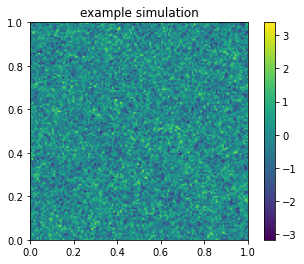

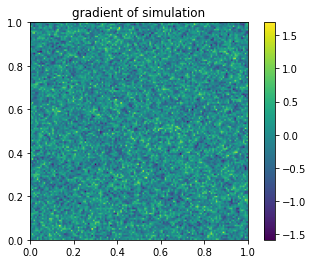

In [16]:
# plot example simulation and derivative
deriv_args = {"N": N, "L": 128, "dim": dim, "shape": field_shape, "vol_norm": True, "N_scale": True, "squeeze": False}
simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, simulator_args=deriv_args)

plt.imshow(np.squeeze(simulation[0]), extent=(0,1,0,1))
plt.colorbar()
plt.title('example simulation')
plt.show()

plt.imshow(np.squeeze(simulation_gradient[0].T[0].T), extent=(0,1,0,1))
plt.title('gradient of simulation')
plt.colorbar()
plt.show()

In [17]:
def get_simulations(rng, n_s, θ, simulator_args=simulator_args):
    def get_simulator(key):
        return simulator(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_simulator)(np.array(keys))


def get_simulation_gradients(rng, n_s, n_d, θ, simulator_args=simulator_args):
    def get_batch_gradient(key):
        return simulator_gradient(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_batch_gradient)(np.array(keys)[:n_d])

# known analytic Fisher information

For a gaussian field, the likelihood is written
$$     \mathcal{L}(\Delta | \theta) = \frac{1}{(2\pi)^{N_p / 2} \det(C)^{1/2}}\exp{\left(-\frac{1}{2} \Delta C^{-1} \Delta \right)}$$

Where $\Delta \in \mathbb{R}^{N_p},\ N_p=N_k=V=N\times N$ is the Fourier Transform of the observed real-space field.
This yields a Fisher information matrix of

$$F_{\alpha \beta} = \langle -\frac{\partial^2 \ln \mathcal{L}}{\partial \lambda_\alpha \partial \lambda_\beta} \rangle= \frac{1}{2} {\rm Tr} (C_{, \alpha} C^{-1} C_{, \beta} C^{-1}) $$
where the covariance is
$$ C_{k_i, k_j} =  P(k_i)\delta_{ij}$$
The associated derivatives for a power law $P(k) = Ak^{-B}$ are
$$\begin{align}
    C_{,A} &= \left( k^{-B} \right)\delta_{ij} \\
    C_{,B} &= \left( -Ak^{-B}\ln k \right) \delta_{ij}
\end{align} $$

We notice that the Fisher information is *only* a function of the power spectrum parameters. It tells us the curvature of the chosen model (likelihood function) at a given $\theta$. The analytic Fisher information is the maximum amount of information we can expect the IMNN to extract from our simulations.

Keeping in mind that the IMNN hasn't been supplied with any information aside from the dimension of the simulation $N\times N  = 128^2$, we will choose our $k$ scale to run from $k_{\rm min} = 1$ to $k_{\rm max} = 128$, corresponding to the number of pixels available at each scale of the simulation.


<!-- Alternatively, we can explore a volume integral analytically from the definition of C :
where the Fisher matrix is given by
$$ F_{\alpha \beta} = \sum_k \frac{1}{(\delta P_k)^2} \frac{\partial P_k}{\partial \lambda_\alpha} \frac{\partial P_k}{\partial \lambda_\beta}$$
and the error on $P_k$ is given (for a square, 2D box) as
$$ \delta P_k = \sqrt{\frac{2}{k (\Delta k) V} } \left( P_k + \frac{1}{\bar{n}} \right) $$ -->

<!-- For a gaussian field, the likelihood is written
$$ \ln \mathcal{L}(\theta | \vec{d}) = \ln \mathcal{L}(\theta | \Delta) = \sqrt{\frac{1}{2\pi C}} \exp{\frac{-{\Delta}^2}{2C}}$$

where $\vec{d} = \Delta$ is the overdensity field (in a cosmological context this is the measured temperature or galaxy count in a sky survey). Given that the power spectrum describes the correlations at different scales $k$, we can define the correlation via the power spectrum $C = P(k) = Ak^{-B}$ to compute the log-likelihood. The Fisher information matrix, given as 
$$ F_{\alpha \beta} = \langle - \frac{\partial^2 \ln \mathcal{L}}{\partial \theta_\alpha \partial \theta_\beta} \rangle $$
can then be computed analytically for our likelihood:
$$ F_{\alpha \beta} = \sum_k \frac{1}{(\delta P_k)^2} \frac{\partial P_k}{\partial \theta_\alpha} \frac{\partial P_k}{\partial \theta_\beta} $$

where $\delta P_k = \sqrt{\frac{2}{4\pi \Delta k V k_{\rm tot}^2}} (P_k + \frac{1}{\bar{n}})$ is the error on $P_k$ with survey volume $V$, sampling interval $\Delta k$, and shot noise $1/\bar{n}$. Using the fact that $d\ln P_k = \frac{d P_k}{P_k}$, we can rewrite the sum as an integral:
$$ F_{\alpha \beta} = 2 \pi \left( \frac{V_{\rm eff}}{\lambda^3} \right) \int_{k_{\rm min}}^{k_{\rm max}} d \ln k  \frac{\partial \ln P_k}{\partial \theta_\alpha} \frac{\partial \ln P_k}{\partial \theta_\beta}$$

Where $V_{\rm eff}$ and $\lambda^3$ are our effective windowed survey size and survey extent, respectively (set to 1 for now). Doing the integration explicitly, we obtain the Fisher matrix for parameters $\theta = (A, B)$:
$$ F = 2 \pi \left( \frac{V_{\rm eff}}{\lambda^3} \right) \begin{bmatrix}
    \frac{1}{A^2} \ln (\frac{k_{\rm max}}{k_{\rm min}}) & \frac{1}{2A} ((\ln k_{\rm min})^2 - (\ln k_{\rm max})^2)  \\
     \frac{1}{2A} ((\ln k_{\rm min})^2 - (\ln k_{\rm max})^2) & \frac{1}{3}((\ln k_{\rm max})^3 - (\ln k_{\rm min})^3)   \\
\end{bmatrix}$$
 -->


In [18]:
import powerbox as pbox

A,B = θ_fid
#sim = np.squeeze(simulator(rng, θ_fid, simulator_args={"N": N, "squeeze":True, "L": L, "dim": 2}))

shape = simulator_args["shape"]
kmax = 0.5 
kmin = 0.5 / N

#kbin = np.linspace(kmin, kmax, num=N**2)
kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))


def fisher_approx(θ, kmin, kmax):
    A,B = θ
    Faa = (1/A)**2 * (np.log(kmax) - np.log(kmin))
    Fab = (1/(2*A)) * ((np.log(kmax))**2 - (np.log(kmin))**2)
    Fbb = ((np.log(kmax))**3 - (np.log(kmin))**3) / 3
    
    return np.array([[Faa, Fab], [Fab, Fbb]]) * 2*np.pi

def fisher(θ, kvec, N=32, dim=2, L=None):
    A,B = θ
    if L is not None:
        V = L**dim
    else: 
        V = N**2     # physical box volume
        
    
    #dk = kvec[1] - kvec[0]
    Nk = N**dim      # number of k modes
    pk = lambda k : A*(k**-B)              # P(k) = Ak^(-B)
    p_a = lambda k : k**-B                # deriv w.r.t. A
    p_b = lambda k : -A*(k**-B)*np.log(k) # deriv w.r.t. B
    
    
    powers = np.concatenate((np.ones(1), 
        (pk(kvec.flatten()[1:])))) 
    
    powera = np.concatenate((np.zeros(1), 
        (p_a(kvec.flatten()[1:]))))
    
    powerb = np.concatenate((np.zeros(1), 
        (p_b(kvec.flatten()[1:])))) 
    
    
    Cinv = np.diag(2. / (powers))          # diagonal inv. covariance
    Ca =  np.diag(powera / 2.)           # C_{,A}
    Cb =  np.diag(powerb / 2.)           # C_{,B}

    Faa = 0.5 * np.trace((Ca @ Cinv @ Ca @ Cinv))
    Fab = 0.5 * np.trace((Ca @ Cinv @ Cb @ Cinv))
    Fba = 0.5 * np.trace((Cb @ Cinv @ Ca @ Cinv))
    Fbb = 0.5 * np.trace((Cb @ Cinv @ Cb @ Cinv))
    
    return np.array([[Faa, Fab], [Fba, Fbb]]) #* 0.5 #* 1 / np.sqrt(2)

For our fiducial model with our data vector of size $128^2$, our $\rm det|F|$ reads:

In [19]:
N

128

In [26]:
N = simulator_args["N"]
shape = simulator_args["shape"]
# kbin = np.sqrt(np.sum(
#     np.array(np.meshgrid(*(np.arange(N // 2) * ((2. * np.pi) / (N))
#                            for N in shape)))**2., 0)).flatten()

# kbin = np.sqrt(np.sum(
#     np.array(np.meshgrid(*(np.arange(N//2) * ((2. * np.pi) / (N))
#                            for N in shape)))**2., 0)).flatten()

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) *2* np.pi / _shape
        for _shape in shape)))**2, axis=0))


print('k array extents: ', '[%f, %f]'%(np.min(kbin), np.max(kbin)))
print('k vector length: ', len(kbin))

f_expected = fisher(θ_fid, kbin[:N//2, :N//2])
print("analytic F(θ_fid): ", f_expected)

detf_expected = np.linalg.det(f_expected)
print("analytic det(F(θ_fid)): ", detf_expected)

k array extents:  [0.000000, 4.442883]
k vector length:  128
analytic F(θ_fid):  [[ 2047.5        -1556.1814602 ]
 [-1556.1814602   1743.09245971]]
analytic det(F(θ_fid)):  1147281.074201786


In [27]:
np.min(kbin[:N//2, :N//2])

DeviceArray(0., dtype=float64)

In [28]:
kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
        for _shape in shape)))**2, axis=0)).flatten()

In [29]:
simulator_args

{'N': 128,
 'L': 128,
 'dim': 2,
 'shape': (128, 128),
 'vol_norm': False,
 'N_scale': True,
 'squeeze': False}

In [37]:
# MAKE SIMULATION
N = simulator_args["N"]
shape = (N,N)

θ_sim = np.array([0.7, 0.8])
simulator_args = {"N": N, "L": 128, "dim": dim, "shape": shape, "vol_norm": True, "N_scale": False, "squeeze": True}
simulator_args["shape"] = (N,N)
simkey,rng = jax.random.split(rng)
#sim = np.squeeze(target_data)#
sim = np.squeeze(simulator(simkey, θ_sim, simulator_args=simulator_args))
sim_fft = (np.fft.fft2(sim)) #/ (N**2)

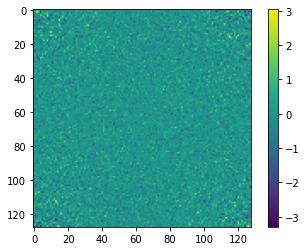

In [38]:
plt.imshow(np.real(sim_fft))
plt.colorbar()

In [39]:
np.mean(sim_fft / N**2)

DeviceArray(-1.1510882e-07+0.j, dtype=complex64)

domain_size 5152.9
(20, 20)


Text(0, 0.5, 'B')

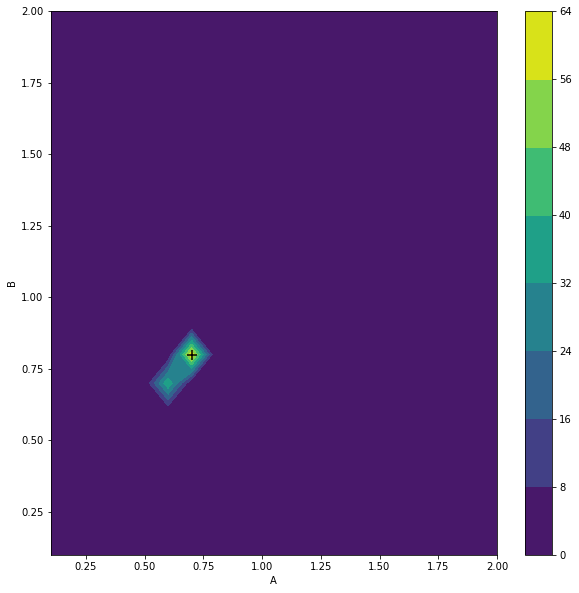

In [43]:
shape = simulator_args["shape"]

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
        for _shape in shape)))**2, axis=0))



def Pk(k, A=1, B=0.5, N=32):
    eps = 1./N
    return (A * (k+eps) ** -B) #/ N**2

def Cov(k, A, B):
    pk = Pk(k, A, B) 

    return np.diag(pk)
def get_likelihood(k, A, B, Δ):
    Δ = Δ.flatten()
    k = k
    
    dlength = len(k.flatten())
    
    def fn(_A, _B):
        
        nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
        nrm = jax.ops.index_update(
          nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
        #nrm = 1
        
        powers = np.concatenate((np.ones(1), 
                (Pk(k.flatten()[1:], A=_A, B=_B))))
        
          
        C = powers * nrm
        invC = np.concatenate((np.zeros(1), 
           (1./Pk(k.flatten()[1:], A=_A, B=_B))))#*np.eye(len(k.flatten()))
        
        logdetC = np.sum(np.log(C))
        pi2 = np.pi * 2.
        m_half_size = -0.5 * len(Δ) #- 0.5* Δ.shape[0] #// 2
        exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
        norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
        return (exponent + norm)
    return jax.vmap(fn)(A, B)

size = 20                # for likelihood gridding
Δ = sim_fft[:N//2, :N//2] #/ N**2
k = kbin[:N//2, :N//2]    

A_start = 0.1
A_end = 2.0
B_start = 0.1
B_end = 2.0

# go by quadrant
qsize = 10

# 3 4
# 1 2

# bottom quadrant 1
A_range = np.linspace(0.1, 1, qsize)
B_range = np.linspace(0.1, 1, qsize)
domain_size = 5152.9 #1. / np.log(1e240)#np.log(1e240) #((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
print('domain_size', domain_size)

A, B = np.meshgrid(A_range, B_range)
likelihood_1 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) + domain_size)

# quadrant 2
A_range = np.linspace(1, 2, qsize)
#domain_size = ((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
A, B = np.meshgrid(A_range, B_range)
likelihood_2 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) + domain_size)

# quadrant 3
A_range = np.linspace(0.1, 1, qsize)
B_range = np.linspace(1, 2, qsize)
#domain_size = ((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
A, B = np.meshgrid(A_range, B_range)
likelihood_3 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) + domain_size)

# quadrant 4
A_range = np.linspace(1, 2, qsize)
#domain_size = ((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
A, B = np.meshgrid(A_range, B_range)
likelihood_4 = np.exp(get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) + domain_size) #** (1/domain_size)
                      
                      
# concatenate results
likelihood = np.concatenate(
    [np.concatenate([likelihood_1, likelihood_2], axis=1),
     np.concatenate([likelihood_3, likelihood_4], axis=1)],
    axis=0)
A_range = np.linspace(0.1, 2, 20)
B_range = np.linspace(0.1, 2, 20)

A, B = np.meshgrid(A_range, B_range)

print(likelihood.shape)


plt.figure(figsize=(10,10))
plt.contourf(A_range, B_range, likelihood)
#plt.contourf(A_range2, B_range2, L2.reshape((size, size)))

plt.colorbar()

plt.scatter(θ_sim[0], θ_sim[1], zorder=10, marker='+', s=100, color='k')

plt.xlabel('A')
plt.ylabel('B')

In [30]:
A_range = np.linspace(0.1, 1, qsize)
B_range = np.linspace(0.1, 1, qsize)
domain_size =  5152.9 #(1e3)#np.log(1e240) #((A_range[1]-A_range[0]) * (A_range[1]-B_range[0]))
print('domain_size', domain_size)

A, B = np.meshgrid(A_range, B_range)
ll = get_likelihood(k, 
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize) + domain_size

domain_size 5152.9


In [31]:
np.max(ll)

DeviceArray(4.1460952+2.53692501e-15j, dtype=complex128)

Text(0, 0.5, 'B')

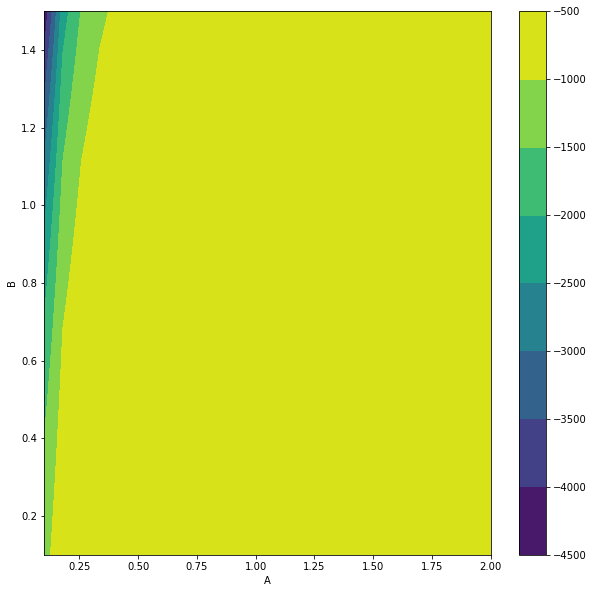

In [267]:

# DOUBLED DATA

N = 32


shape = simulator_args["field_shape"]

θ_sim = np.array([1., 0.5])

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
        for _shape in shape)))**2, axis=0))



def Pk(k, A=1, B=0.5, N=128):
    eps = 1./N
    return (A * (k+eps) ** -B) / 2

def Cov(k, A, B):
    pk = Pk(k, A, B)

    return np.diag(pk)
def log_likelihood(k, A, B, Δ):
    Δ = Δ.flatten()
    k = k
    
    dlength = len(k.flatten())
    
    def fn(_A, _B):
        
        #nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
        #nrm = jax.ops.index_update(
        #  nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
        nrm = 1
        
        powers = np.concatenate((np.ones(1), 
                (Pk(k.flatten()[1:], A=_A, B=_B))))
        
          
        C = powers * nrm
        invC = np.diag(np.concatenate((np.zeros(1), 
           (1./Pk(k.flatten()[1:], A=_A, B=_B)))))
        
        logdetC = np.sum(np.log(C))
        pi2 = np.pi * 2.
        m_half_size = -0.5 * len(Δ)
        exponent = - 0.5 * np.einsum("i,ij,j->", (Δ), (invC), (Δ))
        norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
        return exponent + norm 
    return jax.vmap(fn)(A, B)

size = 25                # for likelihood gridding
Δ = sim_fft[:N, :N]
k = kbin[:N, :N]    
A_start = 0.1
A_end = 2.0
B_start = 0.1
B_end = 1.5
A_range = np.linspace(A_start, A_end, size)
B_range = np.linspace(B_start, B_end, size)
A, B = np.meshgrid(A_range, B_range)
L = log_likelihood(k, A.ravel(), B.ravel(), Δ)

plt.figure(figsize=(10,10))
plt.contourf(A_range, B_range, L.reshape((size, size)))
plt.colorbar()
plt.xlabel('A')
plt.ylabel('B')

In [130]:
# A,B = θ_fid
# # SET L=128 for GRID UNITS DUH !
# # plot a smaller number of k bins
# pk_sim, bins_sim = pbox.get_power(np.real(sim), 128.0, a=0, b=2*np.pi, vol_normalised_power=True)

# plt.plot(bins_sim, pk_sim, label='my sim')
# plt.plot(bins_sim, (A)*bins_sim**-B, label=r'model $Ak^{-B}$')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')

# Initialise IMNN

In [21]:
from IMNN.experimental.jax.imnn._imnn import _IMNN

In [22]:
from IMNN.experimental.jax.imnn._imnn import _IMNN
from IMNN.experimental.jax.utils import check_simulator, value_and_jacrev


class SimIMNN(_IMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator, verbose=True):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            verbose=verbose)
        self.simulator = check_simulator(simulator)
        self.simulate = True

    def get_fitting_keys(self, rng):
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key, validate=False):
        def get_summary(key, θ):
            return self.model(w, self.simulator(key, θ))

        def get_derivatives(key):
            return value_and_jacrev(get_summary, argnums=1)(key, self.θ_fid)

        keys = np.array(jax.random.split(key, num=self.n_s))
        summaries, derivatives = jax.vmap(get_derivatives)(keys[:self.n_d])
        if self.n_s > self.n_d:
            summaries = np.vstack([
                summaries,
                jax.vmap(partial(get_summary, θ=self.θ_fid))(keys[self.n_d:])])
        return np.squeeze(summaries), np.squeeze(derivatives)
    
    
import jax
import jax.numpy as np
from IMNN.experimental.jax.imnn import SimulatorIMNN
from IMNN.experimental.jax.utils import value_and_jacrev, check_devices, \
    check_type, check_splitting


class AggregatedSimulatorIMNN(SimulatorIMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator, devices,
                 n_per_device, verbose=True):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            simulator=simulator,
            verbose=verbose)
        self.devices = check_devices(devices)
        self.n_devices = len(self.devices)
        self.n_per_device = check_type(n_per_device, int, "n_per_device")
        if self.n_s == self.n_d:
            check_splitting(self.n_s, "n_s and n_d", self.n_devices,
                            self.n_per_device)
        else:
            check_splitting(self.n_s, "n_s", self.n_devices, self.n_per_device)
            check_splitting(self.n_d, "n_d", self.n_devices, self.n_per_device)

    def get_summaries(self, w, key=None, validate=False):
        def derivative_scan(counter, rng):
            def get_device_summaries(rng):
                def get_summary(key, θ):
                    return self.model(w, self.simulator(key, θ))

                def get_derivatives(rng):
                    return value_and_jacrev(get_summary, argnums=1)(
                        rng, self.θ_fid)

                keys = np.array(jax.random.split(rng, num=self.n_per_device))
                return jax.vmap(get_derivatives)(keys)

            keys = np.array(jax.random.split(rng, num=self.n_devices))
            summaries, derivatives = jax.pmap(
                get_device_summaries, devices=self.devices)(keys)
            return counter, (summaries, derivatives)

        def summary_scan(counter, rng):
            def get_device_summaries(rng):
                def get_summary(key):
                    return self.model(w, self.simulator(key, self.θ_fid))

                keys = np.array(jax.random.split(rng, num=self.n_per_device))
                return jax.vmap(get_summary)(keys)

            keys = np.array(jax.random.split(rng, num=self.n_devices))
            summaries = jax.pmap(
                get_device_summaries, devices=self.devices)(keys)
            return counter, summaries

        n = self.n_d // (self.n_devices * self.n_per_device)
        if self.n_s > self.n_d:
            n_r = (self.n_s - self.n_d) // (self.n_devices * self.n_per_device)
            key, *keys = jax.random.split(key, num=n_r + 1)
            counter, remaining_summaries = jax.lax.scan(
                summary_scan, n_r, np.array(keys))
        keys = np.array(jax.random.split(key, num=n))
        counter, results = jax.lax.scan(
            derivative_scan, 0, keys)
        summaries, derivatives = results
        if self.n_s > self.n_d:
            summaries = np.vstack([summaries, remaining_summaries])
        return (summaries.reshape((-1, self.n_summaries)),
                derivatives.reshape((-1, self.n_summaries, self.n_params)))



In [23]:
simulator_args["squeeze"] = False

In [27]:
simulator_args['vol_norm'] = True
simulator_args['N_scale'] = True # false 
simulator_args['L'] = 128.0

In [28]:
simulator_args

{'N': 128,
 'L': 128.0,
 'dim': 2,
 'shape': (128, 128),
 'vol_norm': True,
 'N_scale': True,
 'squeeze': False}

In [29]:
IMNN = SimIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
#         devices=[jax.devices()[0]],
#         n_per_device=1000
        )

# Fit

In [189]:
# new_optimiser = jax.experimental.optimizers.sgd(1e-5)
# weights = np.load('./model/best_w.npy',  allow_pickle=True)
# IMNN.opt_initialiser, IMNN.update, IMNN.get_parameters = optimiser
# IMNN.state = IMNN.opt_initialiser(list(weights))

In [190]:
# SAVING IMNN ATTRIBUTES
import cloudpickle as pickle
import os

def save_weights(IMNN, folder_name='./model', weights='final'):
    
    # create output directory
    if not os.path.exists(folder_name): 
        os.mkdir(folder_name)
    
    def pckl_me(obj, path):
        with open(path, 'wb') as file_pi:
            pickle.dump(obj, file_pi)
        file_pi.close()
        
    # save IMNN (optimiser) state:
    savestate = jax.experimental.optimizers.unpack_optimizer_state(IMNN.state)
    pckl_me(savestate, os.path.join(folder_name, 'IMNN_state'))
    
    # save weights
    if weights == 'final':
        np.save(os.path.join(folder_name, 'final_w'), IMNN.final_w)
    
    else:
        np.save(os.path.join(folder_name, 'best_w'), IMNN.best_w)
        
    # save initial weights
    np.save(os.path.join(folder_name, 'initial_w'), IMNN.initial_w)
        
    # save training history
    pckl_me(IMNN.history, os.path.join(folder_name, 'history'))
    
    # save important attributes as a dict
    imnn_attributes = {
        'n_s': IMNN.n_s,
        'n_d': IMNN.n_d,
        'input_shape': IMNN.input_shape,
        'n_params' : IMNN.n_params,            
        'n_summaries': IMNN.n_summaries,
        'θ_fid': IMNN.θ_fid,
        'F': IMNN.F,   
        'validate': IMNN.validate,
        'simulate': IMNN.simulate,
        
    }
    
    pckl_me(imnn_attributes, os.path.join(folder_name, 'IMNN_attributes'))
    
    print('saved weights and attributes to the file ', folder_name)
    
    
def load_weights(IMNN, folder_name='./model', weights='final', load_attributes=True):
    
    
    def unpckl_me(path):
        file = open(path, 'rb')
        return pickle.load(file)
    
    # load and assign weights
    if weights=='final':
        weights = np.load(os.path.join(folder_name, 'final_w.npy'),  allow_pickle=True)
        IMNN.final_w = weights
    else:
        weights = np.load(os.path.join(folder_name, 'best_w.npy'),  allow_pickle=True)
        IMNN.best_w = weights
        
    # re-pack and load the optimiser state
    loadstate = unpckl_me(os.path.join(folder_name, 'IMNN_state'))
    IMNN.state = jax.experimental.optimizers.pack_optimizer_state(loadstate)
    
    
    # load history
    IMNN.history = unpckl_me(os.path.join(folder_name, 'history'))
    
    # load important attributes
    if load_attributes:
        IMNN.intial_w =  np.load(os.path.join(folder_name, 'initial_w.npy'), allow_pickle=True)
        attributes = unpckl_me(os.path.join('test_model', 'IMNN_attributes'))
        IMNN.θ_fid = attributes['θ_fid']
        IMNN.n_s = attributes['n_s']
        IMNN.n_d = attributes['n_d']
        IMNN.input_shape = attributes['input_shape']
        
    print('loaded IMNN with these attributes: ', attributes)
    

In [191]:
# # test save functions
# save_weights(IMNN, folder_name='./model')

# # test load functions

# # initialize a new imnn with different attributes and then load the old file
# # to overwrite them

# my_new_IMNN = SimIMNN(
#         n_s=300,
#         n_d=100,
#         n_params=n_params,
#         n_summaries=n_summaries,
#         input_shape=input_shape,
#         θ_fid=np.array([1.0,1.0]),
#         key=initial_model_key,
#         model=model,
#         optimiser=optimiser,
#         simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
#         )

# load_weights(my_new_IMNN, folder_name='./model', load_attributes=True)
# my_new_IMNN.set_F_statistics(rng, my_new_IMNN.best_w, my_new_IMNN.θ_fid, my_new_IMNN.n_s, my_new_IMNN.n_d, validate=True)

In [30]:
IMNN_rngs = 1 * [fitting_key] #+ 12 * [None]
labels = [
    "Simulator, InceptNet\n"
]

In [31]:
θ_fid

DeviceArray([1. , 0.5], dtype=float32)

In [32]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);
    
#save_weights(IMNN, folder_name='./big_incept128')

CPU times: user 14min 8s, sys: 19 s, total: 14min 27s
Wall time: 14min 40s


In [33]:
IMNNs = [IMNN]

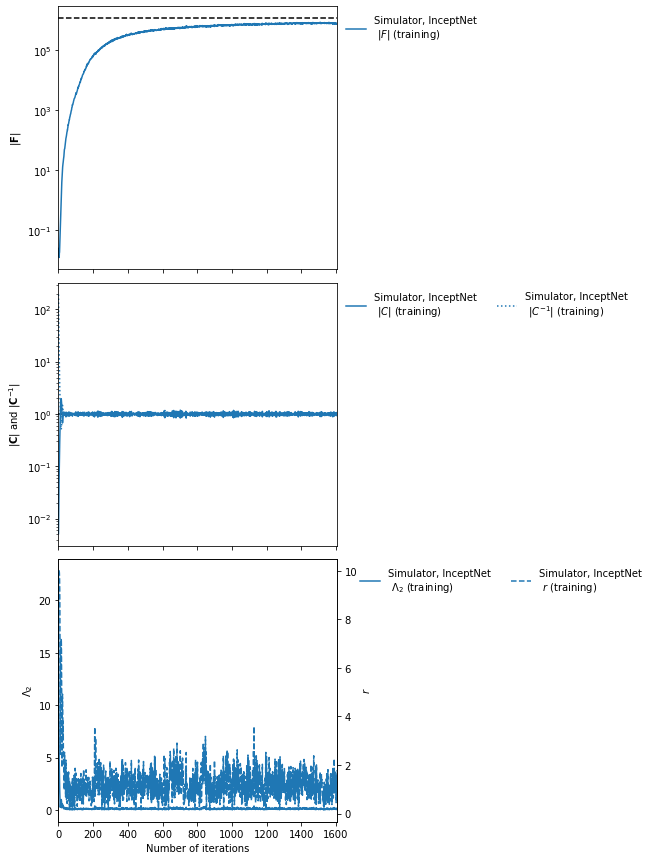

In [34]:
for i, (IMNN, label) in enumerate(zip(IMNNs, labels)):
    if i == 0:
        ax = IMNN.training_plot(expected_detF=detf_expected, colour="C{}".format(i), label=label)
    elif i == 10:
        other_ax = IMNN.training_plot(
            expected_detF=detf_expected, colour="C{}".format(i), label=label
        )
    elif i == 11:
        IMNN.training_plot(
            ax=other_ax,
            expected_detF=50, colour="C{}".format(i), label=label
        )
        other_ax[0].set_yscale("log")
        other_ax[2].set_yscale("log")
    else:
        IMNN.training_plot(
            ax=ax, expected_detF=None, colour="C{}".format(i), label=label, ncol=5
        );
ax[0].set_yscale("log")

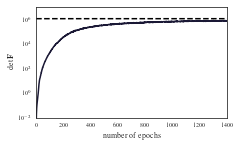

In [46]:
latexify(fig_width=3.37)
plt.plot(IMNN.history['detF'][:])
plt.plot(np.ones(len(IMNN.history['detF'][:]))*detf_expected, c='k', linestyle='--')
plt.ylim(1e-2, 1e7)
plt.ylabel(r'$\det \textbf{F}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-training.png', dpi=400)

In [42]:
np.linalg.det(IMNNs[0].F) #/ (detf_expected)

DeviceArray(730457.7, dtype=float32)

In [35]:
IMNNs[0].F

DeviceArray([[ 2279.2524, -1700.6989],
             [-1700.6989,  1616.3555]], dtype=float32)

In [36]:
print('IMNN F:', IMNN.F)

print('IMNN det F:', np.linalg.det(IMNN.F))

print('IMNN F / analytic det F: ', (np.linalg.det(IMNN.F)) / detf_expected)

IMNN F: [[ 2279.2524 -1700.6989]
 [-1700.6989  1616.3555]]
IMNN det F: 791705.25
IMNN F / analytic det F:  0.6900708708638154


# Data for ABC example

In [92]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)


prior = uniform([0.1, 0.1], [1.25, 1.25])
#prior = uniform([0.1, 0.1], [5.0, 3.0])

In [93]:
simulator_args

{'N': 128,
 'L': 128.0,
 'dim': 2,
 'shape': (128, 128),
 'vol_norm': True,
 'N_scale': True,
 'squeeze': False}

In [99]:
simulator_args = {"N": N, "L": 128, "dim": dim, "shape": shape, "N_scale": True, "vol_norm": True, "squeeze": True}

rng, key = jax.random.split(rng)
θ_target = np.array([0.8, 0.8])
target_data = simulator(
    key,
    θ_target,
    simulator_args={**simulator_args, **{'squeeze':False}})

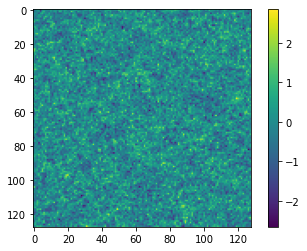

In [100]:
%matplotlib inline
plt.imshow(np.squeeze(target_data))
plt.colorbar()

# analytic likelihood calculation

In [101]:
# computing likelihood function

shape = simulator_args["shape"]

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape
        for _shape in shape)))**2, axis=0))


class analytic_likelihood():
    
    def __init__(self, field_shape,
                 k,
                 Δ,
                 prior,
                 gridsize=20, 
                 tiling=2, 
                ):
        """code for computing a gaussian field's likelihood for power spectrum parameters
            tiling : list or int. tiling=2 means likelihood will be computed as 2x2 grid
        """
        self.field_shape = field_shape
        self.gridsize = gridsize
        if np.isscalar(tiling):
            self.tiling = [tiling]*2
        else:
            self.tiling = tiling    
        #self.tilesize = gridsize // tiling
        self.N = np.sqrt(np.prod(np.array(field_shape)))  # should just be N for NxN grid
        self.prior = prior
        
        self.k = k
        self.Δ = Δ

    def Pk(self, k, A=1, B=0.5, N=32):
        return A*k**-B

    def Cov(self, k, A, B):
        pk = self.Pk(k, A, B) 

        return np.diag(pk)
    def log_likelihood(self, k, A, B, Δ):
        Δ = Δ.flatten()
        k = k

        dlength = len(k.flatten())

        def fn(_A, _B):

            nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
            nrm = jax.ops.index_update(
              nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
            #nrm = 1

            powers = np.concatenate((np.ones(1), 
                    (self.Pk(k.flatten()[1:], A=_A, B=_B))))

            
            C = powers * nrm
            invC = np.concatenate((np.zeros(1), 
               (1./self.Pk(k.flatten()[1:], A=_A, B=_B))))

            logdetC = np.sum(np.log(C))
            pi2 = np.pi * 2.
            m_half_size = -0.5 * len(Δ) #- 0.5* Δ.shape[0] #// 2
            exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ) #np.einsum("i,ij,j->", np.conj(Δ), (invC), (Δ))
            norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
            return (exponent + norm)
        return jax.vmap(fn)(A, B)
    
    def get_likelihood(self, return_grid=False, shift=None):
        A_start = self.prior[0][0]
        A_end = self.prior[1][0]
        B_start = self.prior[0][1]
        B_end = self.prior[1][1]
        
        region_size = [self.gridsize // self.tiling[i] for i in range(len(self.tiling))]
        
        print("computing likelihood on a %dx%d grid \n \
        in tiles of size %dx%d"%(self.gridsize, self.gridsize, region_size[0], region_size[1]))
        
        
        def get_like_region(A0, A1, B0, B1, qsize):
            A_range = np.linspace(A0, A1, qsize)
            B_range = np.linspace(B0, B1, qsize)
            A, B = np.meshgrid(A_range, B_range)

            return (self.log_likelihood(k,
                A.ravel(), B.ravel(), Δ).reshape(qsize,qsize))
        

        
        A_incr = (A_end - A_start) / self.tiling[0]
        B_incr = (B_end - B_start) / self.tiling[1]
        
        # marks the ends of linspace
        A_starts = [A_start + (i)*A_incr for i in range(self.tiling[0])]
        A_ends = [A_start + (i+1)*A_incr for i in range(self.tiling[0])]
        B_starts = [B_start + (i)*B_incr for i in range(self.tiling[1])]
        B_ends = [B_start + (i+1)*B_incr for i in range(self.tiling[1])]
        
        _like_cols = []
        for _col in range(self.tiling[0]):
            # slide horizontally in A
            _like_row = []
            for _row in range(self.tiling[1]):
                # slide vertically in B
                
                    
                _like = get_like_region(A_starts[_row], 
                                        A_ends[_row], 
                                        B_starts[_col], 
                                        B_ends[_col],
                                        region_size[0],
                                        )
                _like_row.append(_like)
                
            _like_cols.append(np.concatenate(_like_row, axis=1))
            
        _log_likelihood = np.real(np.concatenate(_like_cols, axis=0))
        
        if shift is None:
            shift = np.max(_log_likelihood)
            
        print('shift', shift)
        print('loglike mean', np.mean(_log_likelihood))
            
        _log_likelihood = _log_likelihood - shift
        
        if return_grid:
            _A_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            _B_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            return np.exp(_log_likelihood), _A_range, _B_range
        
        return np.exp(_log_likelihood)
    
    
    
    def plot_contours(self, ax=None, θ_ref=None, shift=None, xlabel='A', ylabel='B', return_like=True):
        _like, _A, _B = self.get_likelihood(return_grid=True, shift=shift)
        
        
        _A, _B = np.meshgrid(_A, _B)

        if ax is None:
            fig,ax = plt.subplots(figsize=(10,10))
        
        mesh = ax.contourf(_A, _B, _like)
        plt.colorbar(mesh, ax=ax)

        if θ_ref is not None:
            ax.scatter(θ_ref[0], θ_ref[1], zorder=10, marker='+', s=100, color='r')

        ax.set_xlabel('A')
        ax.set_ylabel('B')
        
        if return_like:
            return _like, ax
        
        else:
            return ax
        
    def plot_corner(self, ax=None, label="Analytic likelihood"):
        
        _like, _A_range, _B_range = self.get_likelihood(return_grid=True)

        likelihoodA = _like.sum(0)
        likelihoodA /= likelihoodA.sum() * (_A_range[1] -  _A_range[0])
        likelihoodB = _like.sum(1)
        likelihoodB /= likelihoodB.sum() * (_B_range[1] -  _B_range[0])
        sorted_marginal = np.sort(_like.flatten())[::-1]
        cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
        value = []
        for level in [0.95, 0.68]:
            this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
            if len(value) == 0:
                value.append(this_value)
            elif this_value <= value[-1]:
                break
            else:
                value.append(this_value)
        
                
        # add in the likelihood estimate
        ax[0, 0].plot(_A_range, likelihoodA, color="C2", label='Analytic likelihood')
        ax[0, 1].axis("off")
        ax[1, 0].contour(_A_range, _B_range, _like, levels=value, colors="C2")
        ax[1, 1].plot(likelihoodB, _B_range, color="C2", label='loglike')
        
        return ax


In [102]:
gridsize = 100                # for likelihood gridding
Δ = np.fft.fftn(np.squeeze(target_data))[:N//2, :N//2] / N
k = kbin[:N//2, :N//2]  
prior_range = np.array([[0.1, 0.1], [1.25, 1.25]])
AL = analytic_likelihood(shape, k, Δ, prior_range, gridsize=gridsize, tiling=[5,5])

computing likelihood on a 100x100 grid 
         in tiles of size 20x20
shift -5472.014503993501
loglike mean -6343.237601490712
CPU times: user 2.75 s, sys: 81.8 ms, total: 2.84 s
Wall time: 2.68 s


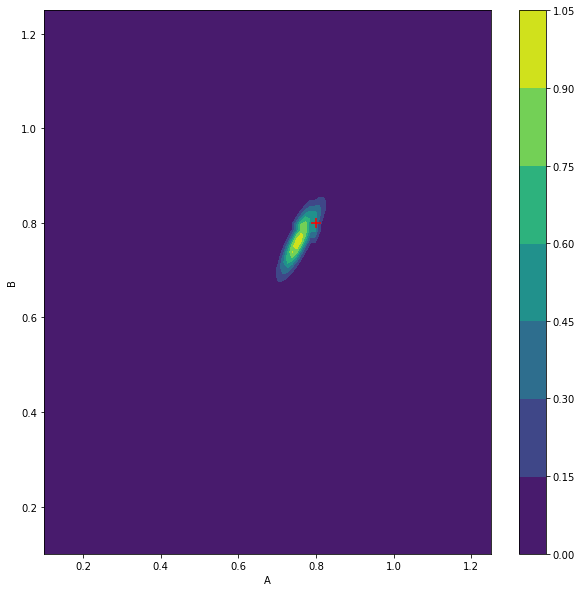

In [103]:
%%time
%matplotlib inline
#plt.style.use('default')
likelihood,_ = AL.plot_contours(θ_ref=θ_target, shift=None, xlabel=r'$A$', ylabel=r'$B$', return_like=True)

# Gaussian approximation

In [63]:
IMNN.set_F_statistics(IMNN.best_w, key=rng, validate=True);

TypeError: convolution requires lhs and rhs ndim to be equal, got 3 and 4.

In [104]:
@jit #partial(jax.jit, static_argnums=0)
def get_estimate(d):
    if len(d.shape) == 1:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,l->i",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)
    else:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,ml->mi",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)

In [105]:
estimates = get_estimate(target_data) #[i.get_estimate(target_data) for i in IMNNs];

In [106]:
detf_expected

DeviceArray(1147281.07420179, dtype=float64)

In [107]:
GAs = [GaussianApproximation(get_estimate(target_data), IMNN.invF, prior)]
       #GaussianApproximation(get_estimate(target_data), np.linalg.inv(f_expected), prior)]

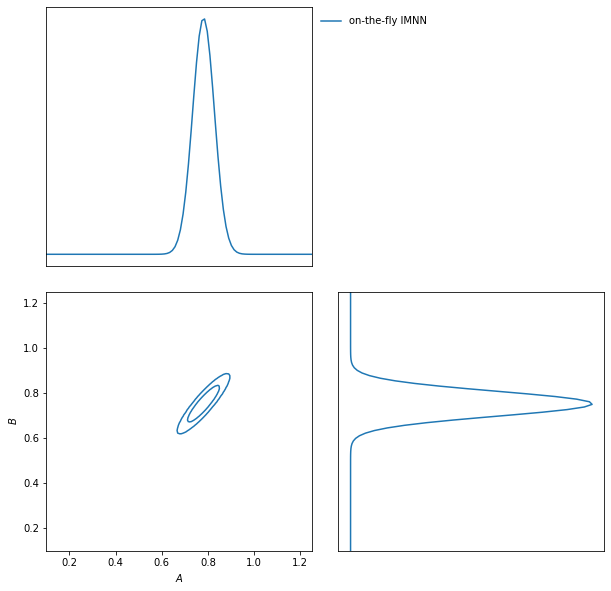

In [108]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$A$", r"$B$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

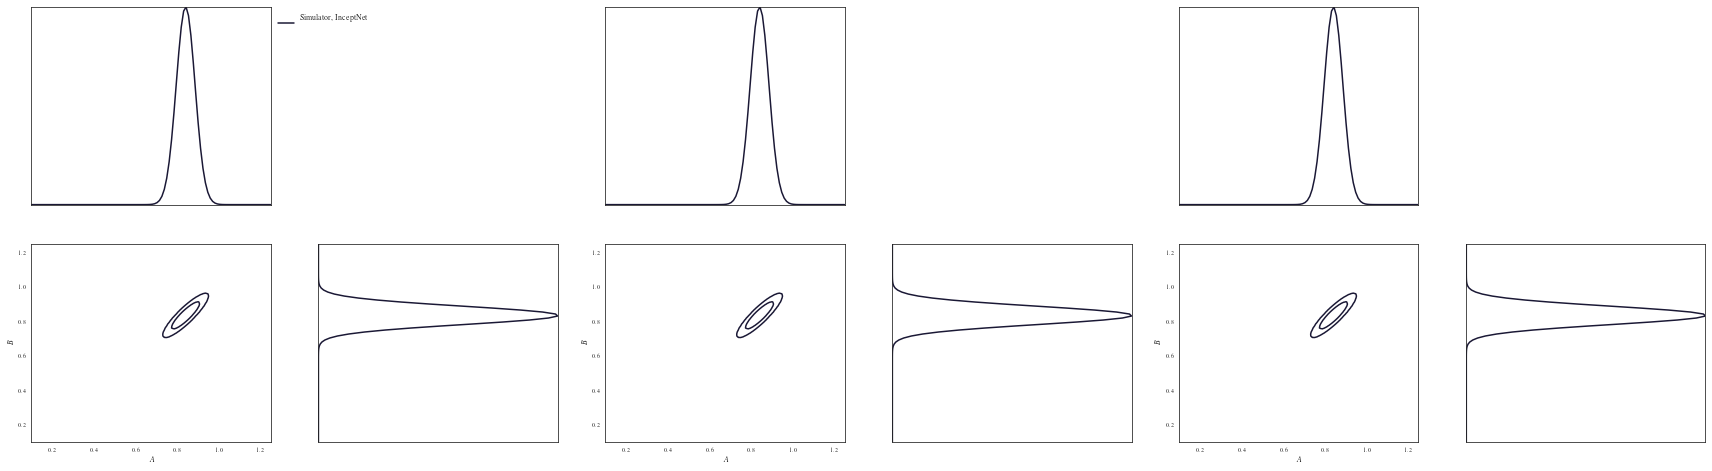

In [70]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax1 = GA.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$A$", r"$B$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = GA.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$A$", r"$B$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = GA.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$A$", r"$B$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        GA.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        GA.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        GA.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

# ABC

In [109]:
{**simulator_args, **{'squeeze':True}}

{'N': 128,
 'L': 128,
 'dim': 2,
 'shape': (128, 128),
 'N_scale': True,
 'vol_norm': True,
 'squeeze': True}

In [110]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':True}}), 
                                       get_estimate, F=IMNN.F, gridsize=50
    )

In [229]:
ABCs = [
    ApproximateBayesianComputation(
        target_data, prior, simulator, IMNN.get_estimate, F=IMNN.F, gridsize=50
    )
    for IMNN, estimate in zip(IMNNs, estimates)
]

IndexError: tuple index out of range

In [133]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=20000,
        ϵ=0.05,
        smoothing=0.);

130 accepted in last  20000 iterations  (20000000 simulations done).
CPU times: user 4min 7s, sys: 5.08 s, total: 4min 12s
Wall time: 4min 16s


(<IMNN.experimental.jax.utils.container.container at 0x1553e093b940>,
 <IMNN.experimental.jax.utils.container.container at 0x1553e093b780>)

In [134]:
ABC.parameters.accepted[0].shape

(506, 2)

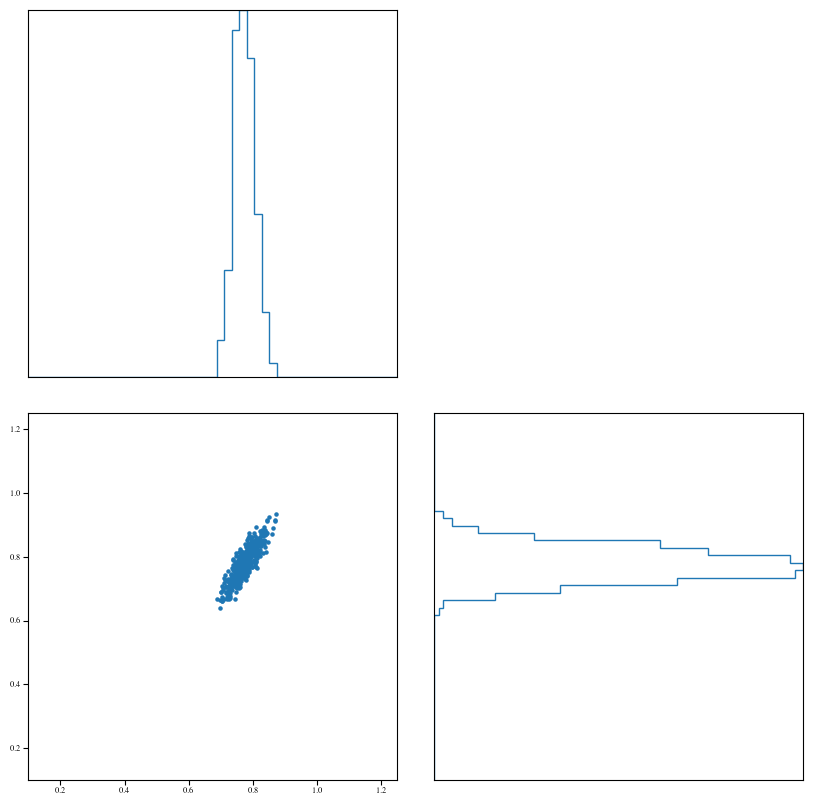

In [135]:
#ax = ABC.scatter_plot(points=ABC.parameters.rejected, colours='red')
ax = ABC.scatter_plot()

In [95]:
np.save("accepted.npy", ABC.parameters.accepted)

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

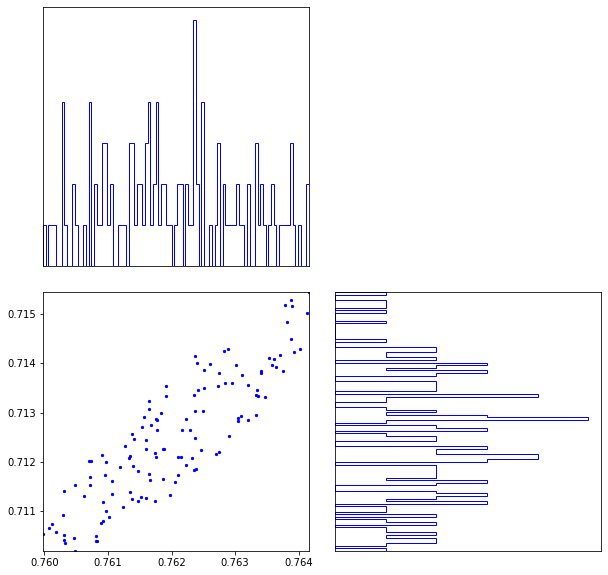

In [96]:
#ax = ABC.scatter_summaries(points=ABC.summaries.rejected, colours='red')
ABC.scatter_summaries( colours='blue')

In [114]:
print('$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

m target} = A,B = (0.80,0.80)$


In [115]:
likelihood,A_range,B_range = AL.get_likelihood(return_grid=True)

computing likelihood on a 100x100 grid 
         in tiles of size 20x20
shift -5472.014503993501
loglike mean -6343.237601490712


In [116]:
#A_range = np.linspace(0.1, 3.0, 25)
#B_range = np.linspace(0.1, 2.5, 25)
likelihoodA = np.real(likelihood).sum(0)
likelihoodA /= likelihoodA.sum() * (A_range[1] -  A_range[0])
likelihoodB = np.real(likelihood).sum(1)
likelihoodB /= likelihoodB.sum() * (B_range[1] -  B_range[0])
sorted_marginal = np.sort(np.real(likelihood).flatten())[::-1]
cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
value = []
for level in [0.95, 0.68]:
    this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
    if len(value) == 0:
        value.append(this_value)
    elif this_value <= value[-1]:
        break
    else:
        value.append(this_value)
#fig, ax = plt.subplots(2, 2, figsize=(10, 10))


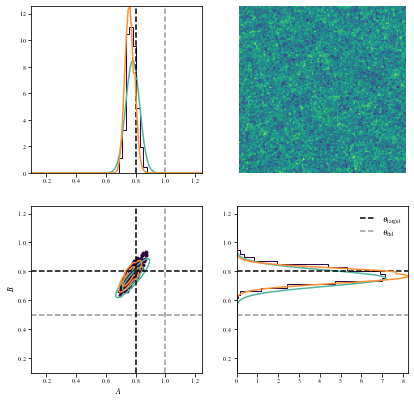

In [160]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
latexify(fig_width=3.37, fig_height=3.37)

ABC.scatter_plot(ax=ax,
                      colours=new_colors[0], 
                      axis_labels=[r"$A$", r"$B$"], 
                      s=8,
                      label='ABC estimate')
# ABC.marginal_plot(ax=ax,
#             axis_labels=[r"$A$", r"$B$"], colours='green',
#             label='ABC marginal plot')


GAs[0].marginal_plot(ax=ax, colours=new_colors[2], axis_labels=[r"$A$", r"$B$"], label=None, ncol=1)
ax[0,1].imshow(target_data[0, 0])

#ax[0,1].set_title(r'$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$A$')
ax[1,0].set_ylabel(r'$B$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
#ax[1,0].contourf(A_range, B_range, L1.reshape((size, size)))
#ax[0, 0].plot(A_range, np.real(loglikeA), color='g', label='loglikeA')

ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

#ax[1,1].plot(np.real(loglikeB), B_range, color='g', label='loglikeB')
ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label=None)
ax[0, 1].axis("off")
ax[1, 0].contour(A_range, B_range, np.real(likelihood), levels=value, colors='#FF8D33')
ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='loglike')

ax[0,0].legend(framealpha=0.)

plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-contours.png', dpi=400)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [121]:
# compare fishers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(θ, fisher, ax, n_std=1.0, facecolor='none', **kwargs):
    
    A,B = θ


    cov = fisher #np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    #ell_radius_x = np.sqrt(1 + pearson)
    #ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = A #np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = B #np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [122]:
(fabs[0,1]) / np.sqrt((fabs[0,0]*fabs[1,1]))

0.8043829617726415

In [123]:
fabs = np.abs(f_expected)

In [126]:
fig,ax = plt.subplots(1,1)
ax.scatter(θ_fid[0], θ_fid[1], marker='+', s=30, zorder=10, color='r')
confidence_ellipse(θ_fid, f_expected, ax=ax, edgecolor='green')
confidence_ellipse(θ_fid, 1/IMNN.F, ax=ax, edgecolor='blue')
plt.xlabel('A')
plt.ylabel('B')
plt.show()

/mnt/home/tmakinen/anaconda3/envs/pyjax/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

In [261]:
loglike = np.real(L1.reshape(size,size))
loglike += np.abs(loglike.min()) 
loglike /= loglike.max()

loglikeA = np.exp(loglike.sum(0))
loglikeA /= loglikeA.sum() * (A_range[1] - A_range[0])

In [262]:
loglike += np.abs(loglike.min()) 
loglike /= loglike.max()

loglikeB = np.exp(loglike.sum(1))
loglikeB /= loglikeB.sum() * (B_range[1] - B_range[0])

Need to provide `marginal` or run `get_marginals()`


TypeError: 'NoneType' object is not subscriptable

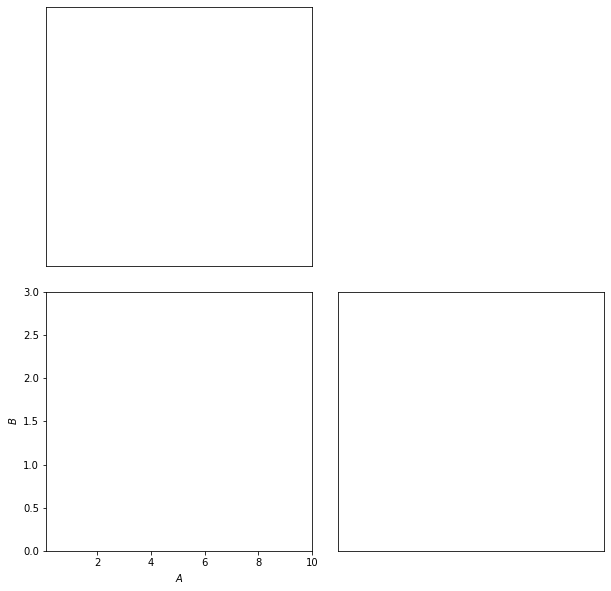

In [229]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax = ABC.marginal_plot(
            axis_labels=[r"$A$", r"$B$"], label=label, colours="C{}".format(i)
        )
    else:
        ABC.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

In [230]:
[
    ABC(
        rng=abc_key,
        n_samples=int(1e2),
        min_accepted=1000,
        max_iterations=1000,
        ϵ=0.1,
        smoothing=1,
    )
    for ABC in ABCs
];

TypeError: convolution requires lhs and rhs ndim to be equal, got 5 and 4.

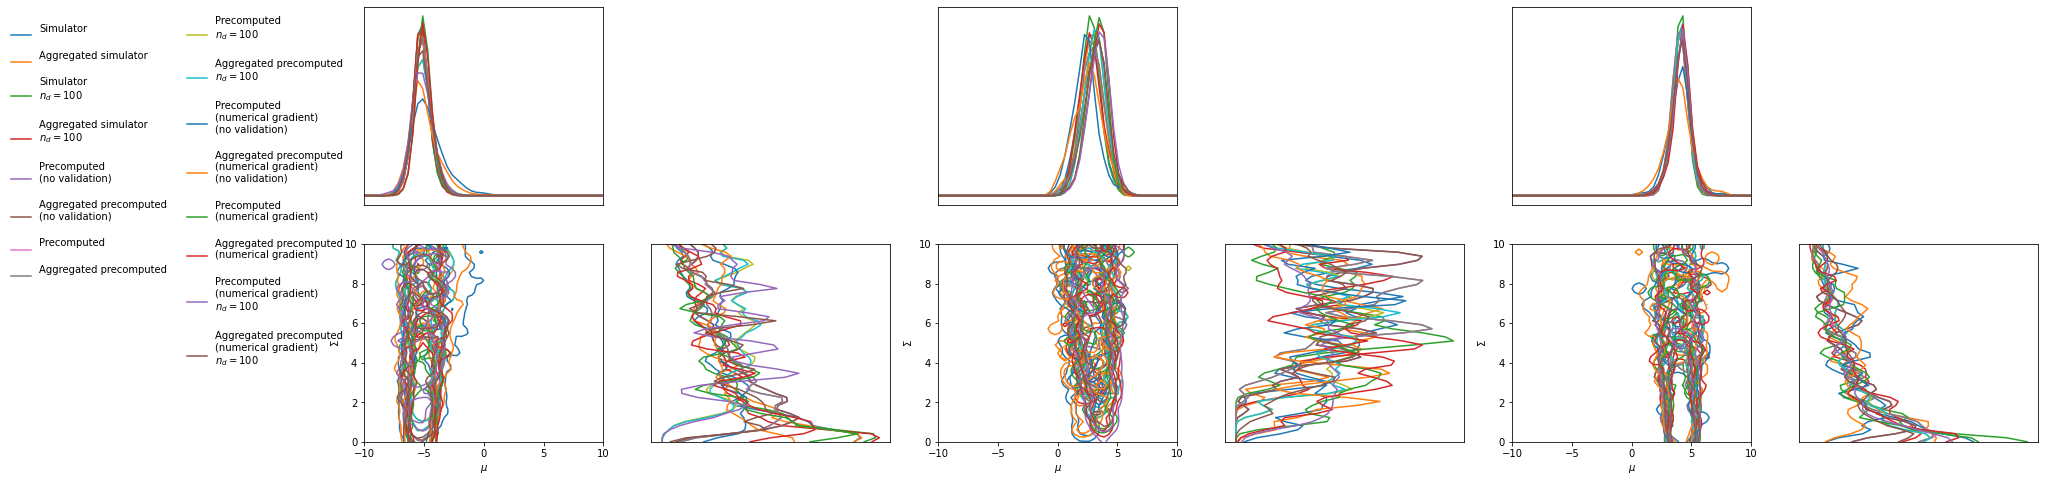

In [46]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax1 = ABC.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = ABC.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = ABC.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        ABC.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        ABC.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        ABC.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

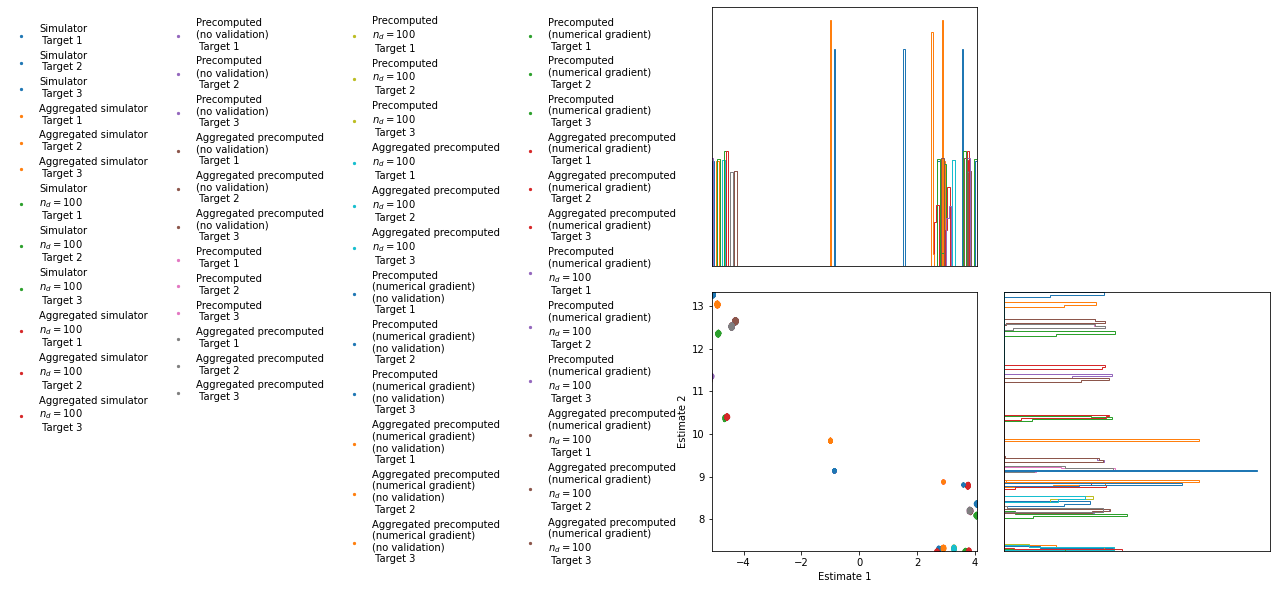

In [50]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax = ABC.scatter_summaries(
            axis_labels=["Estimate 1", "Estimate 2"],
            label=label,
            colours="C{}".format(i),
        )
    else:
        ABC.scatter_summaries(ax=ax, label=label, colours="C{}".format(i), ncol=4, bbox_to_anchor=(-0.1, 1.0))

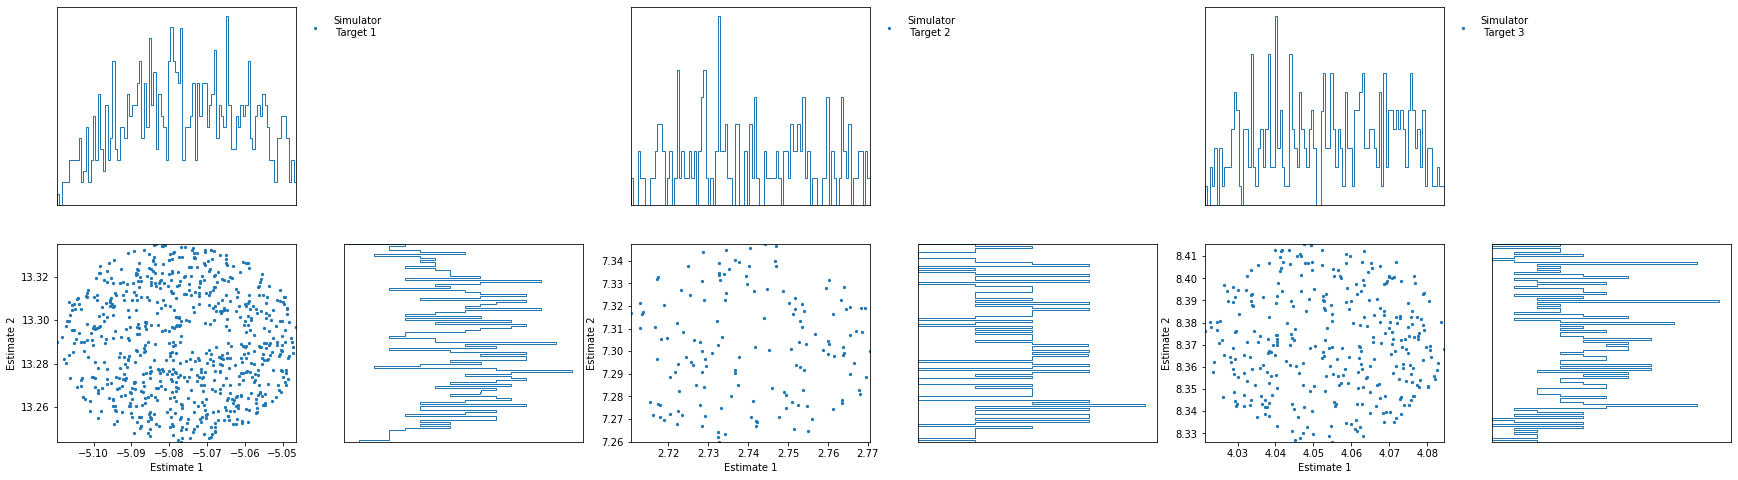

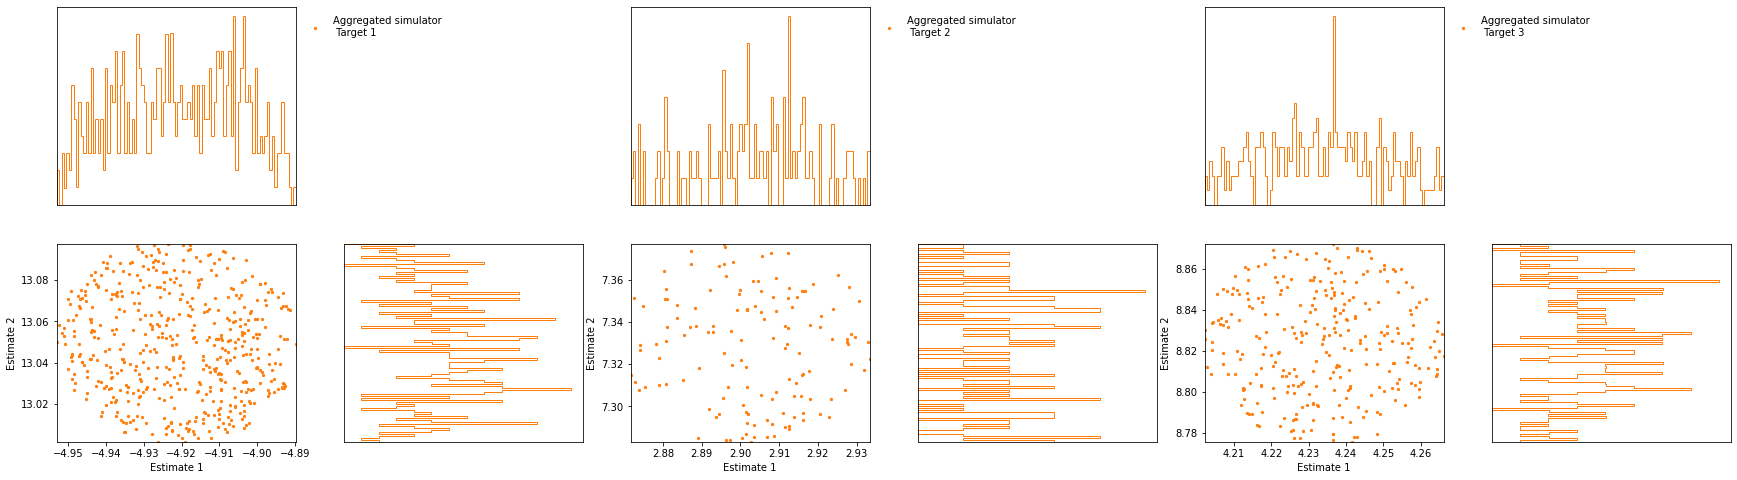

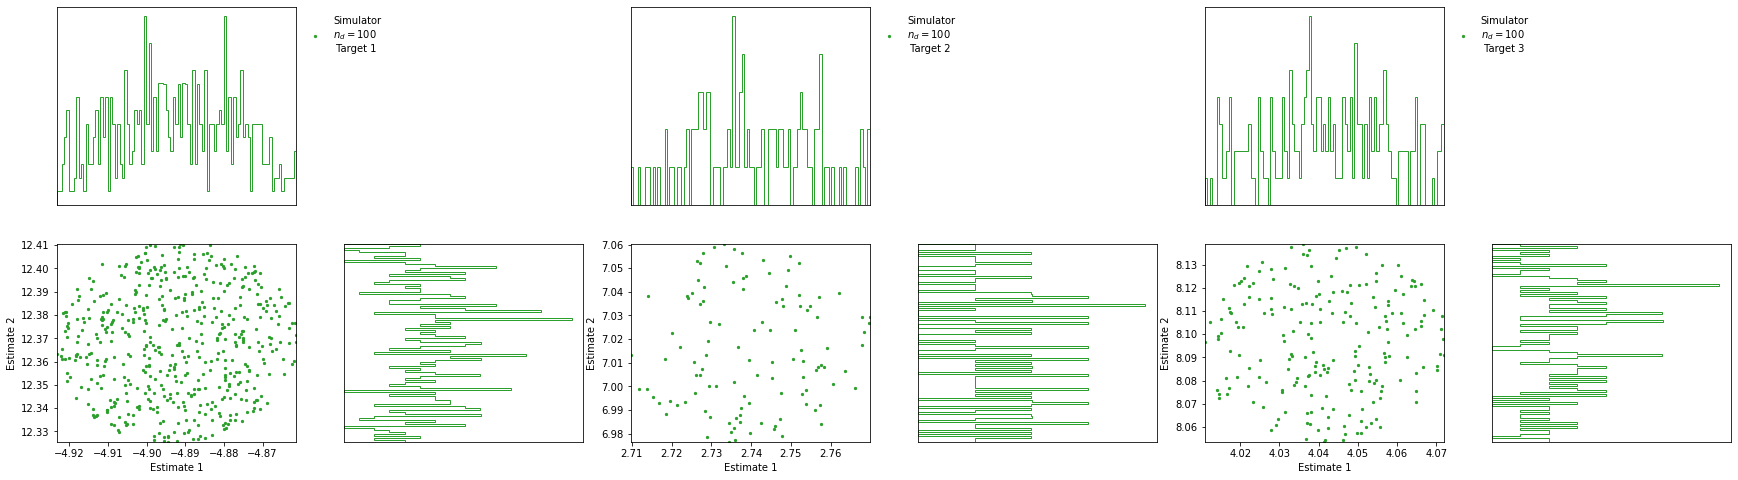

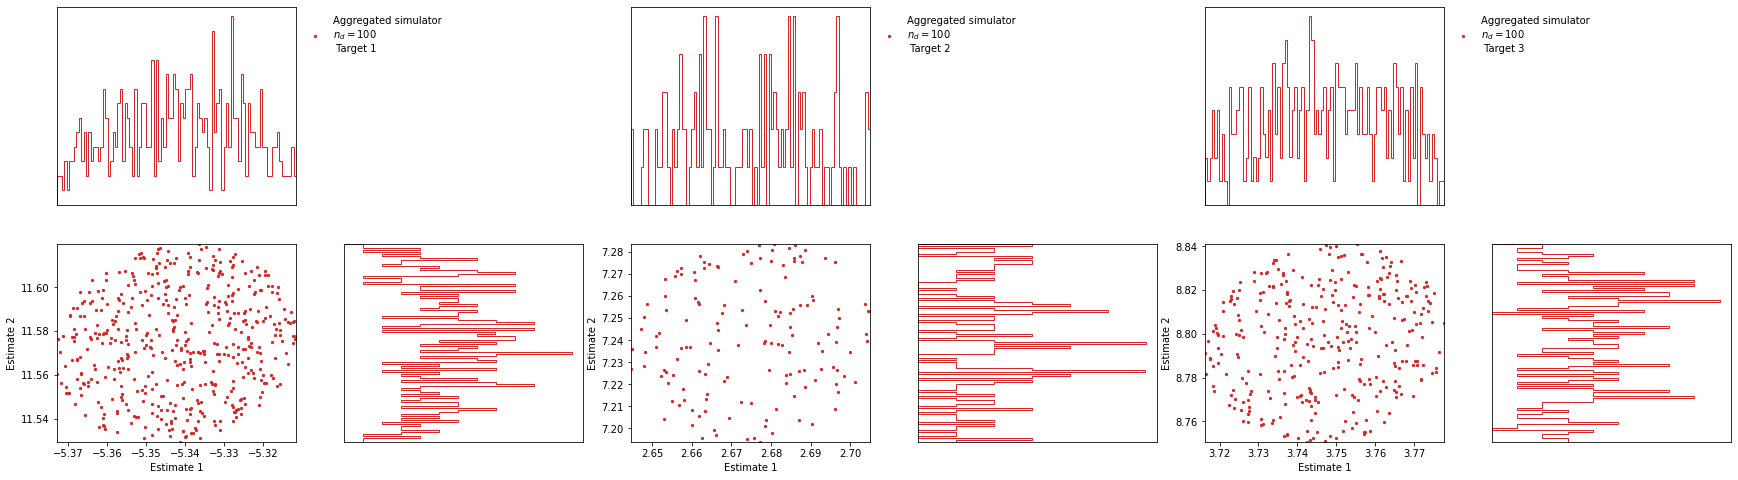

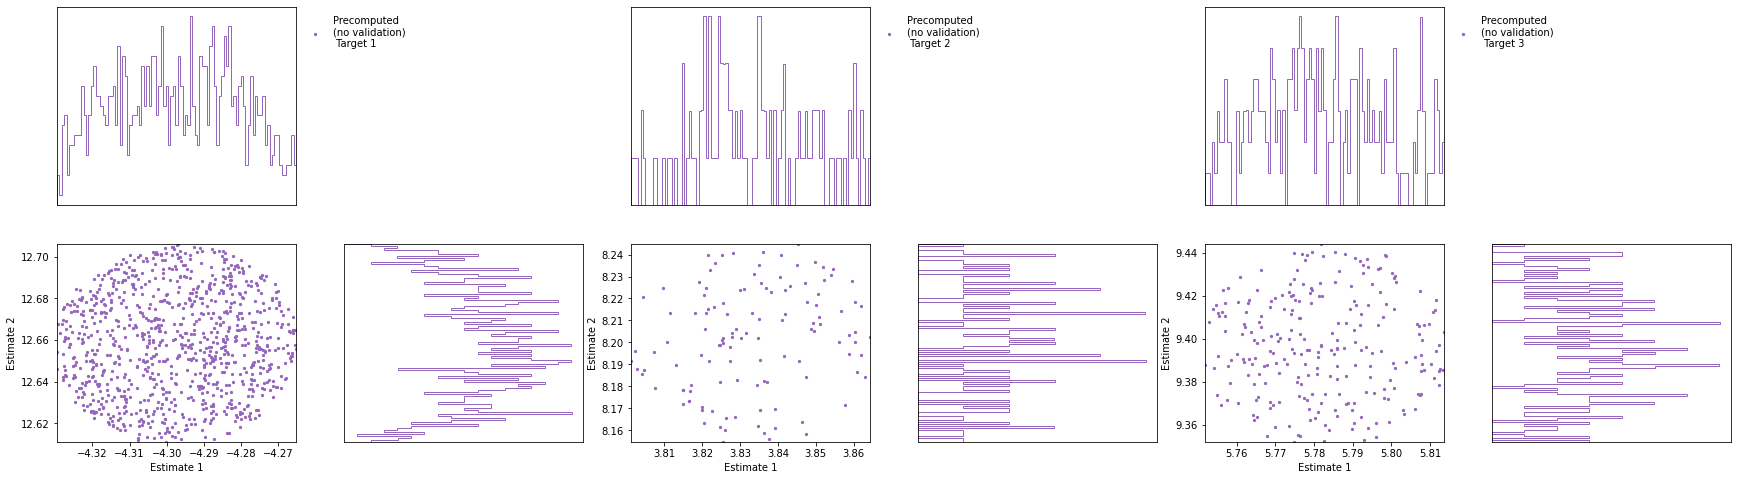

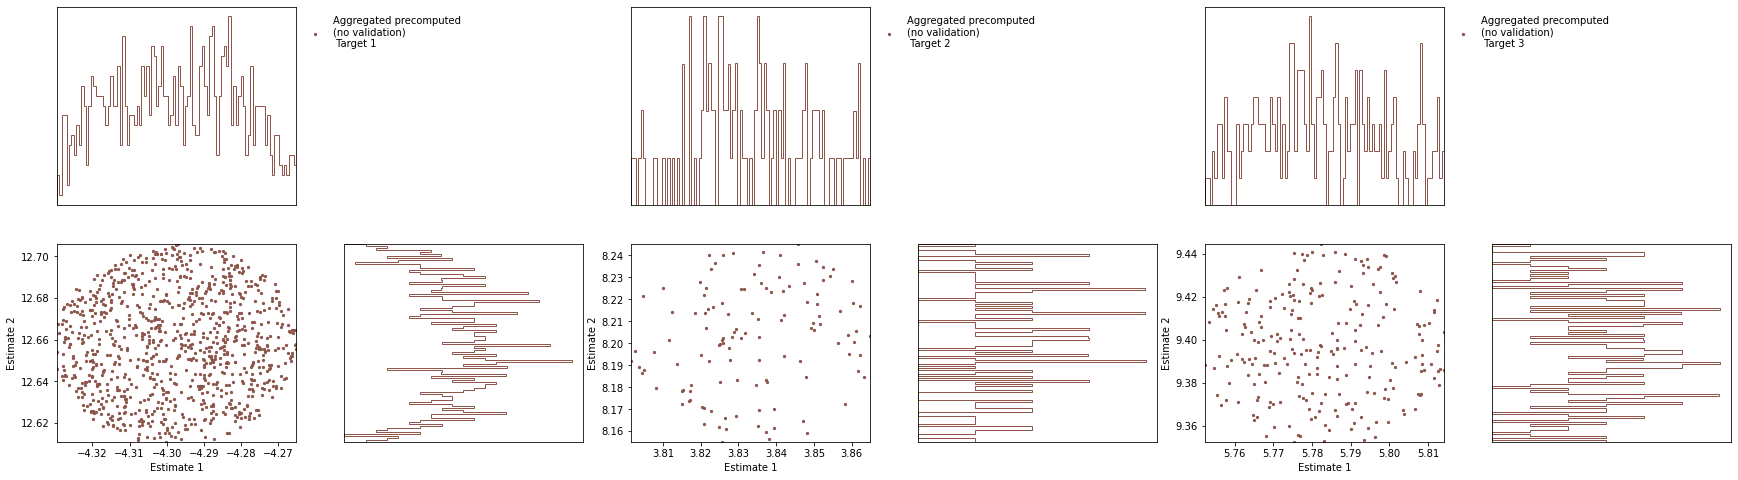

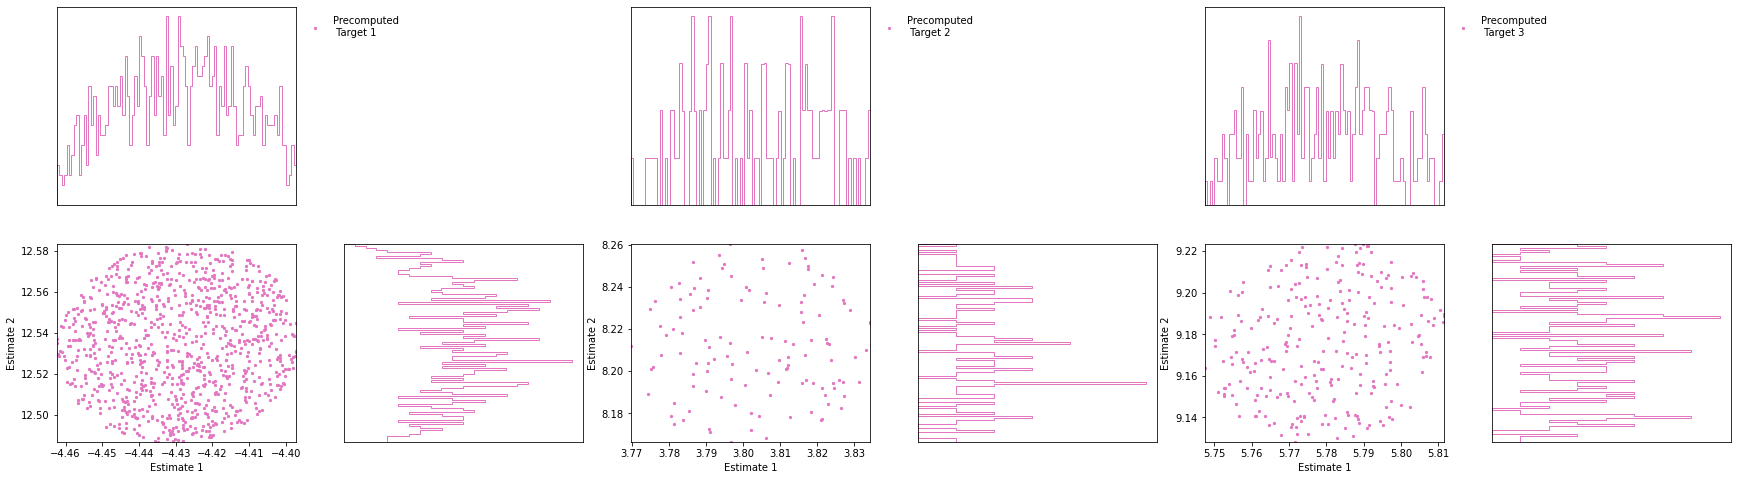

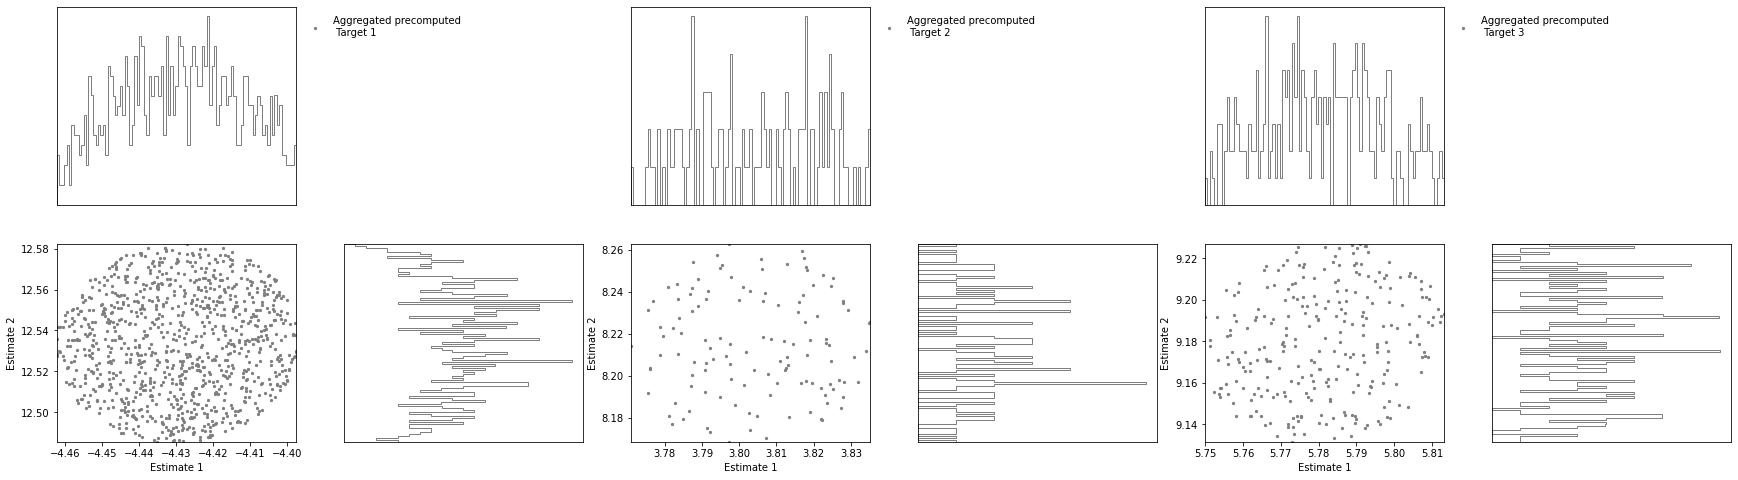

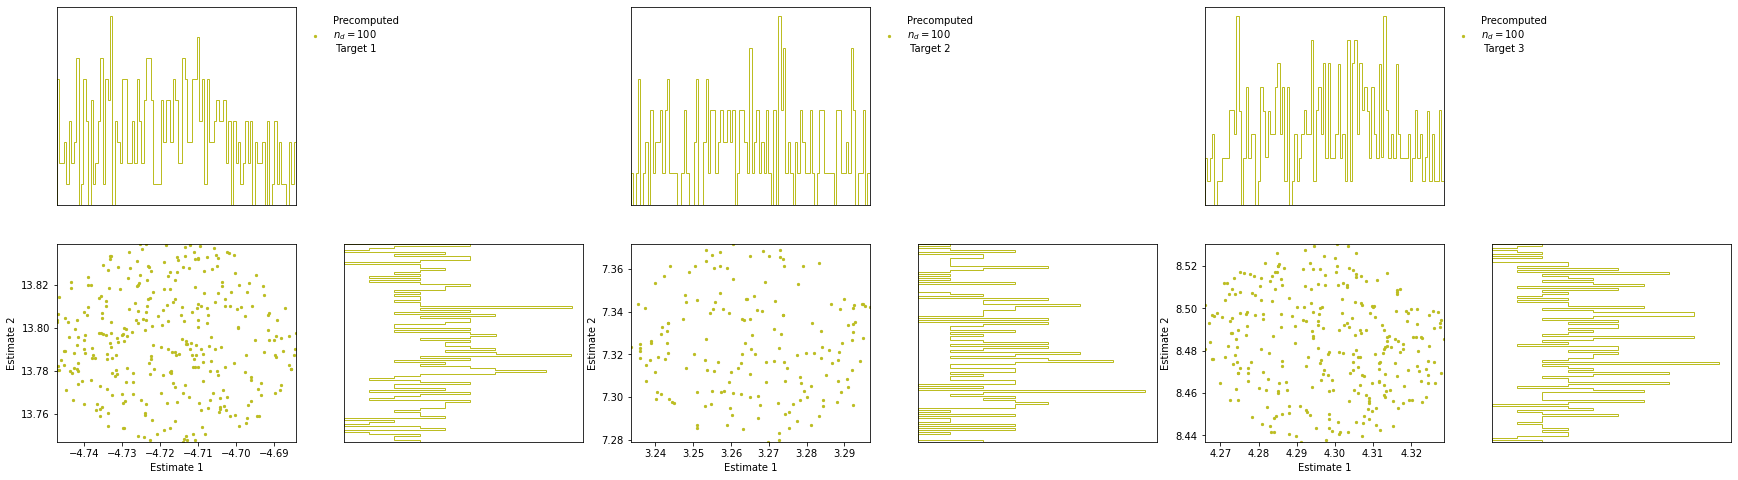

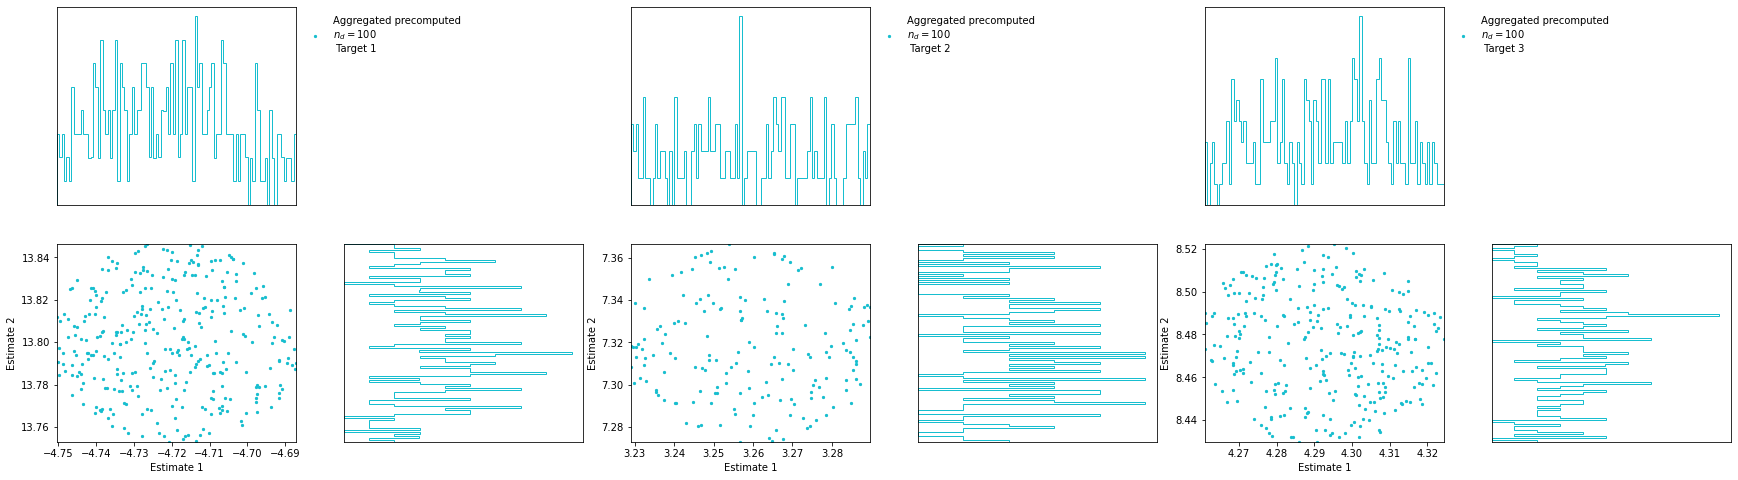

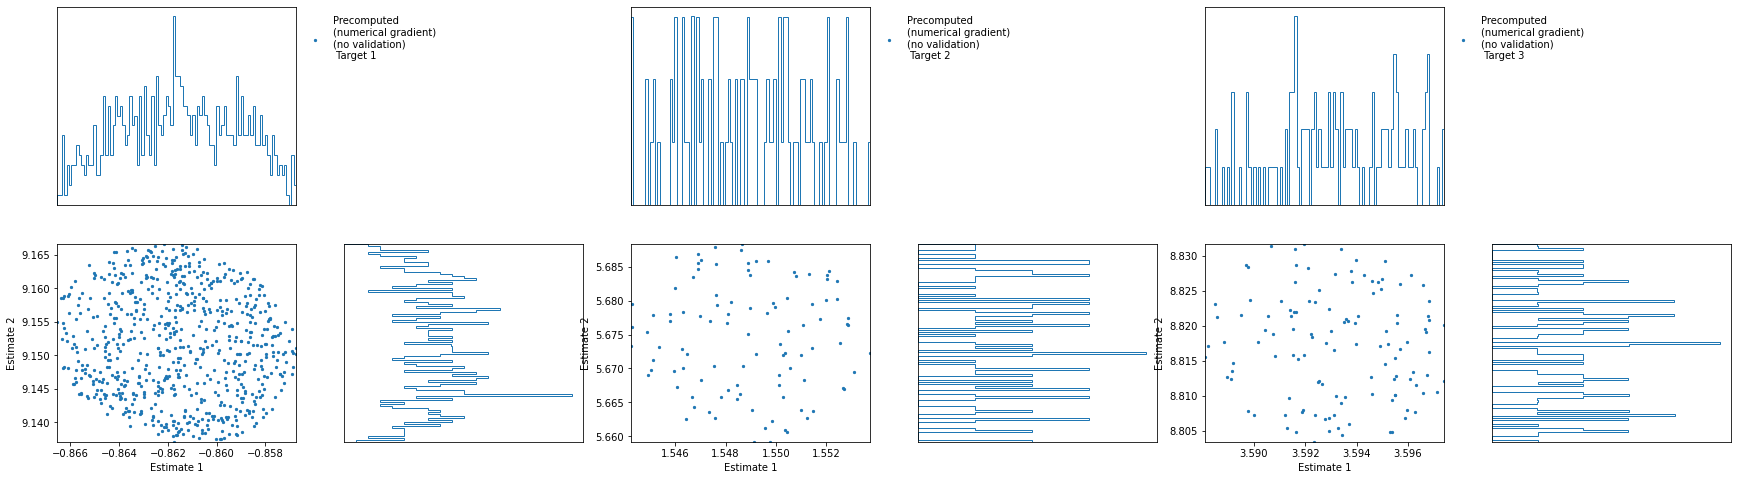

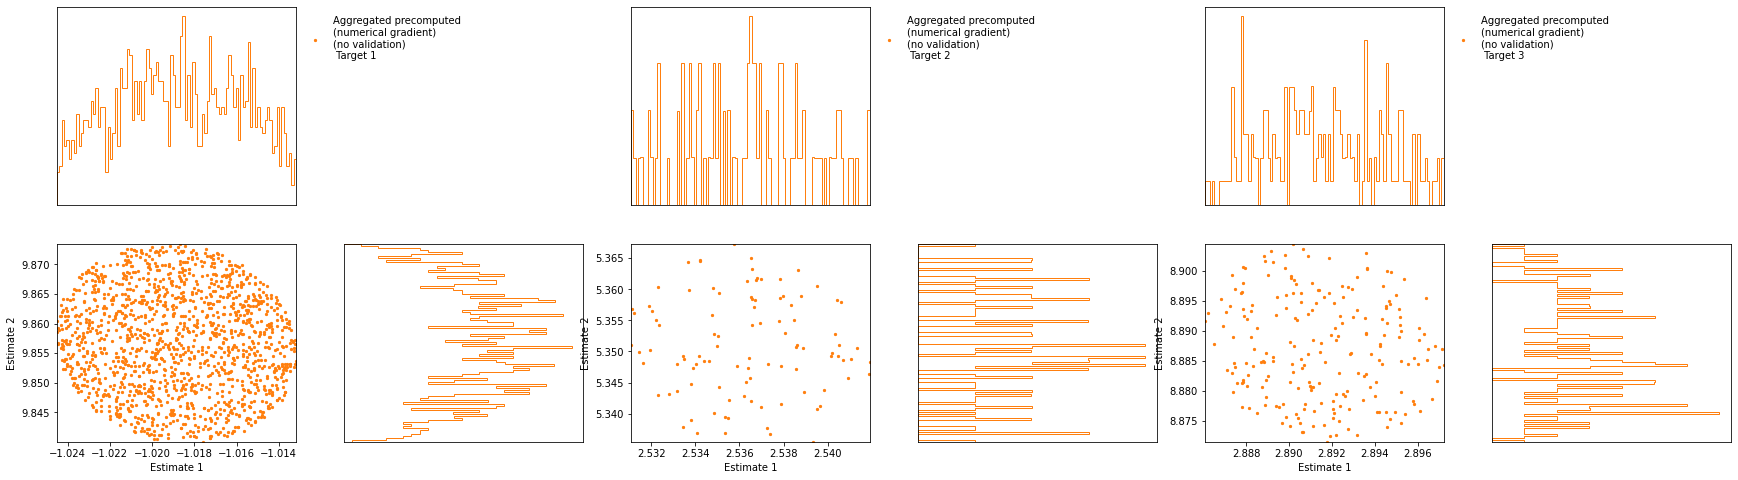

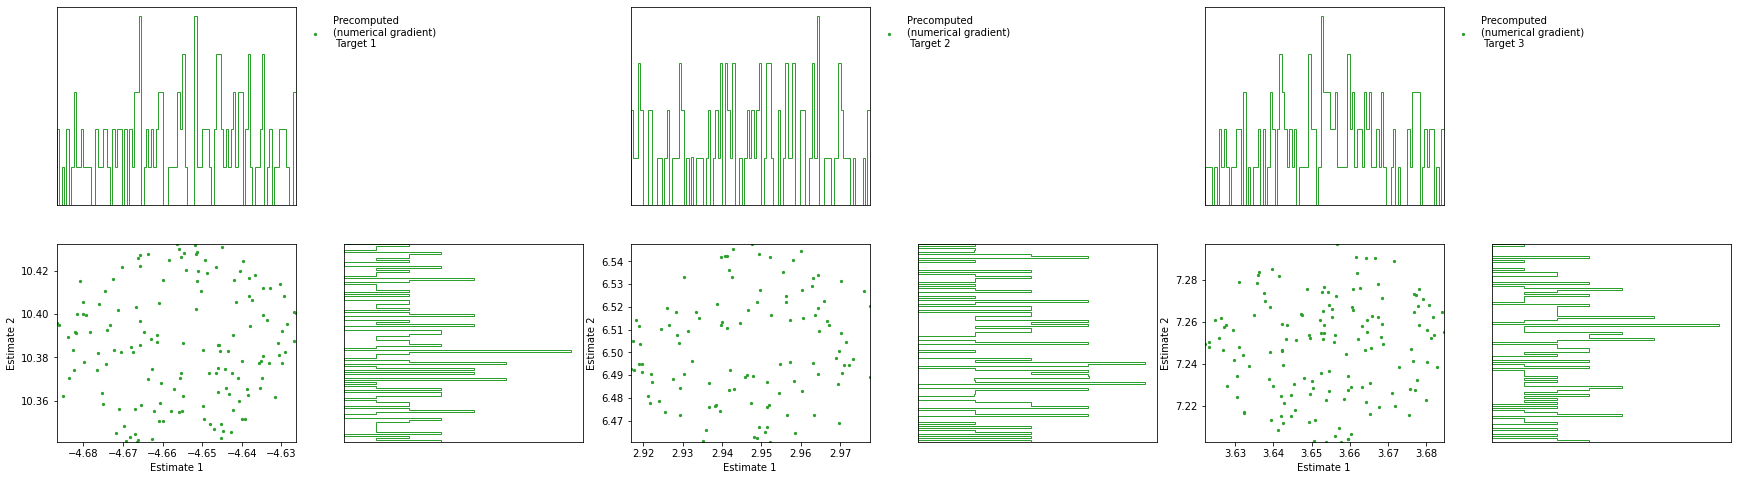

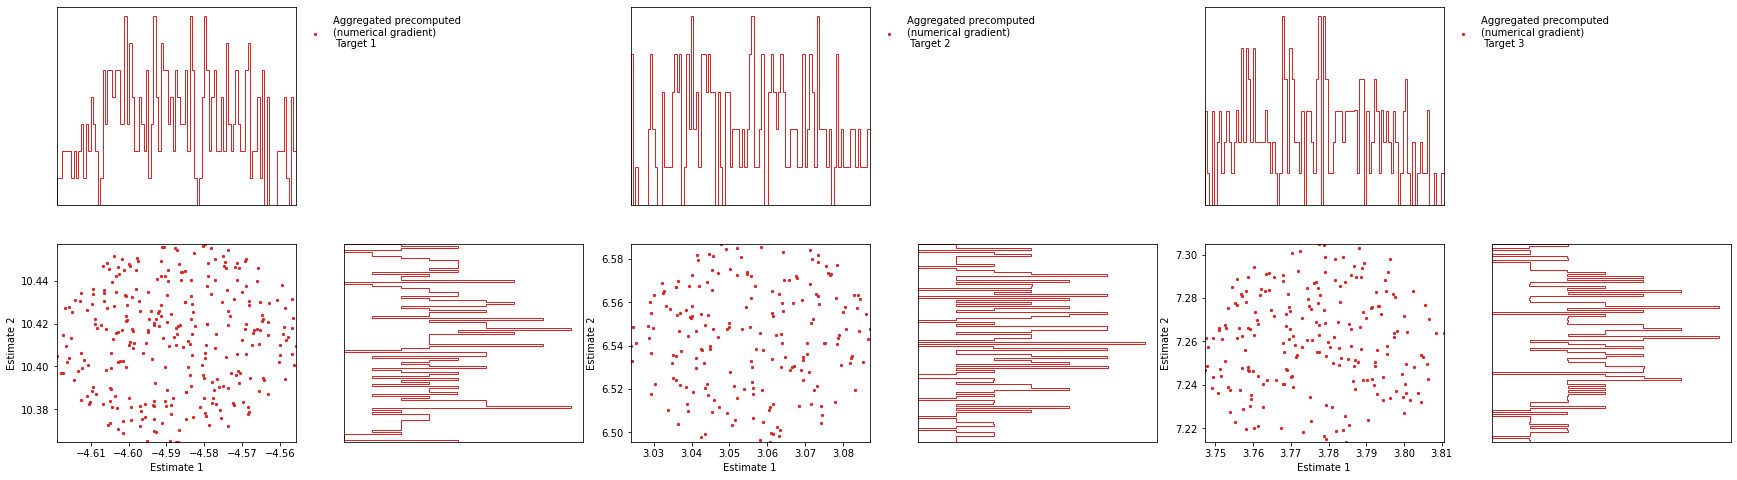

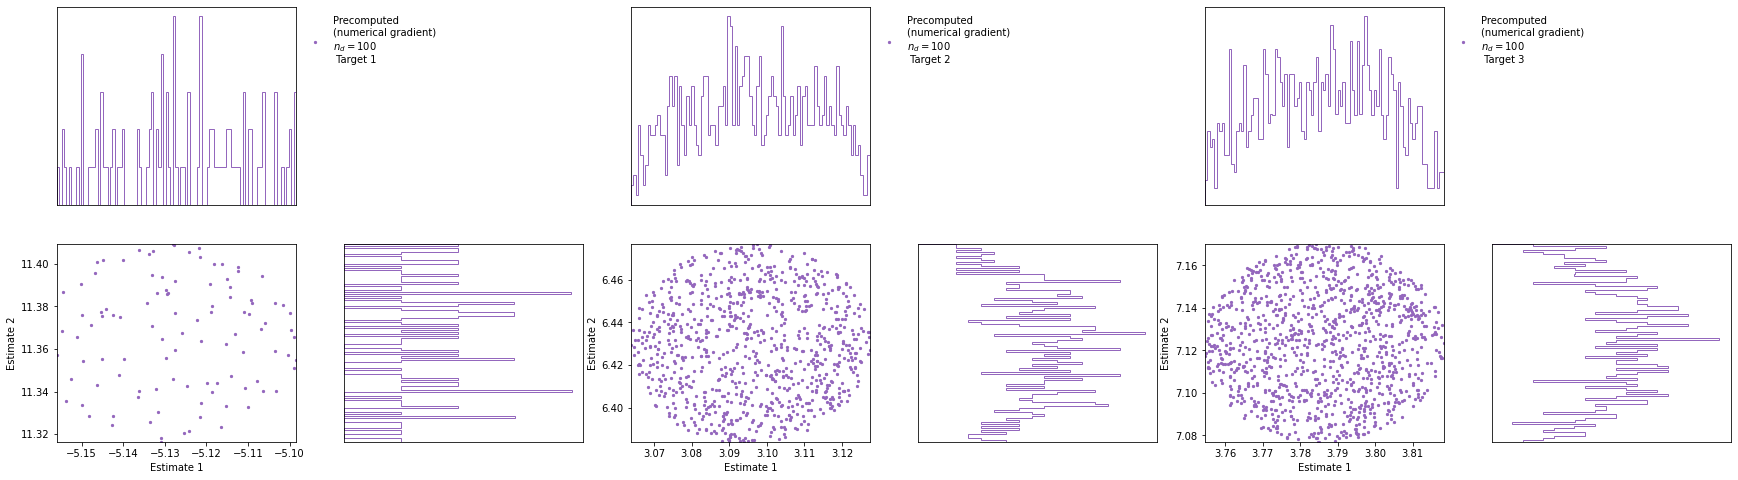

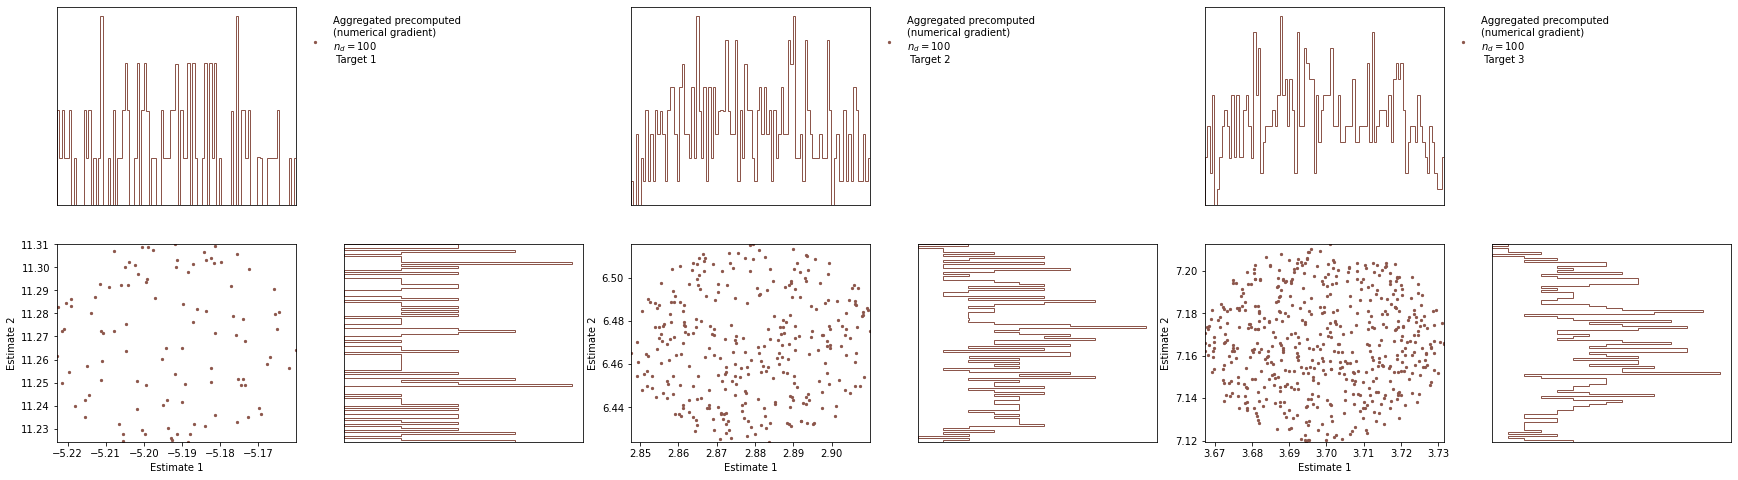

In [48]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    fig, ax = plt.subplots(2, 6, figsize=(30, 8))
    ABC.scatter_summaries(
        ax=ax[:, :2],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=0,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )
    ABC.scatter_summaries(
        ax=ax[:, 2:4],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=1,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )
    ABC.scatter_summaries(
        ax=ax[:, 4:],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=2,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )

In [10]:
# Create figures in Python that handle LaTeX, and save images to files in my
# preferred formatting. I typically place this code in the root of each of my
# projects, and import using:
# from latexify import *
# which will also run the latexify() function on the import.

# Based on code from https://nipunbatra.github.io/blog/2014/latexify.html

import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

#Back-end to use depends on the system
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
# matplotlib.use('pgf')
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# matplotlib.backend_bases.register_backend('ps', FigureCanvasPgf)

import seaborn as sns
sns.set_style("white")

#my preferred palette. From
#https://seaborn.pydata.org/tutorial/color_palettes.html: "The cubehelix color
#palette system makes sequential palettes with a linear increase or decrease in
#brightness and some variation in hue. This means that the information in your
#colormap will be preserved when converted to black and white (for printing) or
#when viewed by a colorblind individual."

# I typically set the number of colors (below, 8) to the distinct colors I need
# in a given plot, so as to use the full range.
sns.set_palette(sns.color_palette("cubehelix", 8))


# The following is the latexify function. It allows you to create 2 column or 1
# column figures. You may also wish to alter the height or width of the figure.
# The default settings are good for most cases. You may also change the
# parameters such as labelsize and fontsize based on your classfile.
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1, 2])

    if fig_width is None:
        fig_width = 6.9 if columns == 1 else 13.8  # width in inches #3.39

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    MAX_HEIGHT_INCHES = 16.0
    if fig_height > MAX_HEIGHT_INCHES:
        print(("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches."))
        fig_height = MAX_HEIGHT_INCHES

    params = {
            # 'backend': 'ps',
           #   'pgf.rcfonts': False,
           #   'pgf.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
           #   "pgf.texsystem": "pdflatex",
             # 'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
              'text.latex.preamble': '\\usepackage{mathptmx}',
              #values below are useful defaults. individual plot fontsizes are
              #modified as necessary.
              'axes.labelsize': 8,  # fontsize for x and y labels
              'axes.titlesize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 6,
              'ytick.labelsize': 6,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'Times',
               'lines.linewidth': 1.5,
               'lines.markersize':1,
               'xtick.major.pad' : 2,
               'ytick.major.pad' : 2,
                'axes.xmargin' :  .0,  # x margin.  See `axes.Axes.margins`
                'axes.ymargin' : .0,  # y margin See `axes.Axes.margins`
              }

    matplotlib.rcParams.update(params)

def saveimage(name, fig = plt, extension = 'pdf', folder = 'plots/'):
    sns.despine()

    #Minor ticks off by default in matplotlib
    # plt.minorticks_off()

    #grid being off is the default for seaborn white style, so not needed.
    # plt.grid(False, axis = "x")
    # plt.grid(False, axis = "y")
    
    fig.savefig('{}{}.{}'.format(folder,name, extension), bbox_inches = 'tight')

latexify()